# Load packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

tsai       : 0.2.17
fastai     : 2.3.1
fastcore   : 1.3.19
torch      : 1.8.1+cu111


In [3]:
torch.cuda.get_device_name(0)

'GeForce RTX 2070'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import ticker

In [5]:
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
           'legend.fontsize': med,
           'figure.figsize': (10, 6),
           'axes.labelsize': med,
           'axes.titlesize': med,
           'xtick.labelsize': med,
           'ytick.labelsize': med,
           'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

# Version
print(mpl.__version__)
print(sns.__version__)

3.3.2
0.11.0


In [6]:
import hyperopt
print(hyperopt.__version__)
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp
from hyperopt import space_eval

0.2.5


In [7]:
import time
from fastai.callback.tracker import EarlyStoppingCallback
import gc

In [8]:
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Specify parameters

In [9]:
file_name = "../OD_pair/CERNET-OD_pair.csv"  # the input filename
history = 10  # input historical time steps
horizon = 1  # output predicted time steps
test_ratio = 0.2  # testing data ratio
max_evals = 100  # maximal trials for hyper parameter tuning

model_name = 'LSTM'
y_true_fn = '%s_true_TM-minmax-%d-%d.pkl' % (model_name, history, horizon)
y_pred_fn = '%s_pred_TM-minmax-%d-%d.pkl' % (model_name, history, horizon)

RMSE_fn = model_name + '_TM-minmax_RMSE-%d-%d-step-%d.pdf'
MAE_fn = model_name + '_TM-minmax_MAE-%d-%d-step-%d.pdf'

In [10]:
y_true_fn

'LSTM_true_TM-minmax-10-1.pkl'

In [11]:
y_pred_fn

'LSTM_pred_TM-minmax-10-1.pkl'

# Load data

In [12]:
df = pd.read_csv(file_name)

In [13]:
df.head()

time        OD_1-1       OD_1-2        OD_1-3        OD_1-4  \
0  2013-02-19-22-10  3.897921e+06  3660.257162  2.038509e+06  54492.199769   
1  2013-02-19-22-15  3.714310e+06  4102.475155  2.010658e+06  44398.935617   
2  2013-02-19-22-20  3.824844e+06  3475.827556  2.022040e+06  39446.603085   
3  2013-02-19-22-25  3.967014e+06  3616.911661  2.005270e+06  42316.578675   
4  2013-02-19-22-30  3.708735e+06  3464.036062  2.017856e+06  44239.873981   

          OD_1-5         OD_1-6         OD_1-7         OD_1-8        OD_1-9  \
0  234230.295946   84819.101740  326551.951138   70567.750666  12520.192382   
1  200445.246659  118932.827733  345145.938997   73246.388000  13969.378085   
2  191539.466968  143379.788071  380456.462916   88085.648186  13683.572258   
3  171440.464195  139779.197759  399477.041689  100997.455279  13928.180880   
4  150425.682249  134512.997369  388659.765735   95906.154986  12303.793875   

   ...  OD_14-5  OD_14-6   OD_14-7      OD_14-8  OD_14-9      OD_14-10  \
0  ...      0.0      0.0  0.000000  1381.832533      0.0  10897.764534   
1  ...      0.0      0.0  0.000000  1123.647467      0.0  10333.189333   
2  ...      0.0      0.0  0.000000  1430.037600      0.0   9900.663200   
3  ...      0.0      0.0  0.000000  1954.184000      0.0  10663.956267   
4  ...      0.0      0.0  0.083324  3102.597333      0.0   7687.432800   

   OD_14-11      OD_14-12  OD_14-13  OD_14-14  
0       0.0  36048.613333       0.0       0.0  
1       0.0  32883.840000       0.0       0.0  
2       0.0  28923.253333       0.0       0.0  
3       0.0  34839.440000       0.0       0.0  
4       0.0  35943.493333       0.0       0.0  

[5 rows x 197 columns]

Parse the time column:

In [14]:
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d-%H-%M')  # Parse the time

In [15]:
data_columns = list(df.columns.values)
data_columns.remove('time')
data = df[data_columns].values
# data = np.clip(data, 0.0, np.percentile(data.flatten(), 99))  # we use 99% as the threshold
# df[data_columns] = data

# Split the data

Split the data based on the test_ratio parameter. Aggreate the data and plot the training/testing split first:

In [16]:
aggregated_time_series = np.sum(data, axis=1)
df_ts = pd.DataFrame()
df_ts['date'] = df['time']
df_ts['data'] = aggregated_time_series / 1000  # Plot in Mbps

# add a datetimeindex
dates = pd.DatetimeIndex(df_ts['date'])
df_ts = df_ts.set_index(dates).asfreq('5T') 

In [17]:
test_length = int(df.shape[0] * test_ratio)
train_length = df.shape[0] - test_length

In [18]:
df_ts.index[train_length:][0]

Timestamp('2013-03-19 16:50:00', freq='5T')

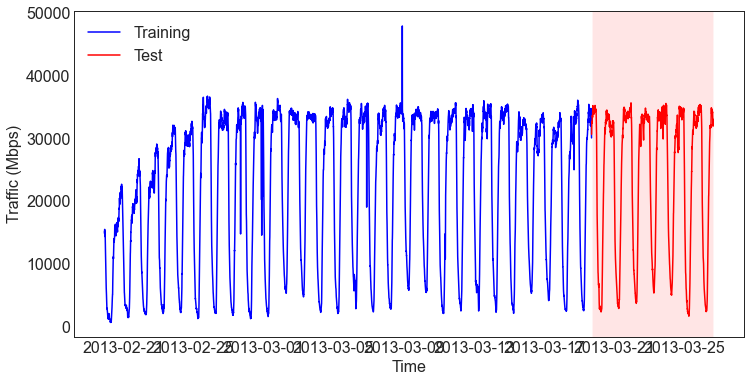

In [19]:
plt.figure(figsize=[12, 6])
plt.plot(df_ts.index[:train_length], df_ts['data'][:train_length], label='Training', color='blue')
plt.plot(df_ts.index[train_length:], df_ts['data'][train_length:], label='Test', color='red')
plt.axvspan(df_ts.index[train_length:][0], df_ts.index[train_length:][-1],  facecolor='r', alpha=0.1)

plt.xlabel('Time')
plt.ylabel('Traffic (Mbps)')
plt.legend(loc='best')
# plt.show()
plt.savefig('training_test_split.pdf', bbox_inches = 'tight', pad_inches = 0.1)

Plot the training / testing split:

# Normalize the data

Calculate the min and max data based on the training data set:

In [20]:
max_list = np.max(data[:train_length], axis=0)

In [21]:
min_list = np.min(data[:train_length], axis=0)

Normalize the data and fill the data:

In [22]:
data = (data - min_list) / (max_list - min_list)
data[np.isnan(data)] = 0  # fill the abnormal data with 0
data[np.isinf(data)] = 0

In [23]:
print(np.max(data[:train_length].flatten()))

1.0


In [24]:
print(np.min(data[:train_length].flatten()))

0.0


The training data is in a range of [0, 1] but the test data may be out of this range:

In [25]:
print(np.max(data.flatten()))

2.0845760812827483


In [26]:
print(np.min(data.flatten()))

-0.004873735825012876


# Build the supervised prediction problem

The input data is in the following format:
* x_data as input features: [data size, input historical steps, input channels]. Here the input channel number is the OD pair number.
* y_data as output targets: [data size, output prediction steps, output channels].

In [27]:
x_data = []
y_data = []

In [28]:
length = data.shape[0]
print(length)

9999


In [29]:
for i in range(length - history - horizon + 1):
    x = data[i:i+history, :]  # input historical time steps
    y = data[i+history:i+history+horizon:, :]  # output predicted time steps
    x_data.append(x)
    y_data.append(y)

In [30]:
x_data = np.array(x_data)
y_data = np.array(y_data)

In [31]:
x_data.shape

(9989, 10, 196)

In [32]:
y_data.shape

(9989, 1, 196)

Reshape x_data:

In [33]:
x_data = np.swapaxes(x_data, 1, 2)

**This format is required by tsai: [data size, input channels, input historical steps].**

Reshape y_data:

In [34]:
y_data = y_data.reshape(y_data.shape[0], -1)
y_data.shape

(9989, 196)

The last test_length samples are fixed as test data. The training data size may vary with the input historical time steps. The test data size may vary with the prediction horizon.

In [35]:
test_length = test_length - horizon + 1

In [36]:
train_valid_length = x_data.shape[0] - test_length

In [37]:
train_valid_length

7990

We further split a valid data set for hyper parameter tuning:

In [38]:
train_length = int(train_valid_length * 0.8)
valid_length = train_valid_length - train_length

In [39]:
train_length

6392

In [40]:
valid_length

1598

In [41]:
X_train = x_data[:train_length]
y_train = y_data[:train_length]
X_valid = x_data[train_length:train_valid_length]
y_valid = y_data[train_length:train_valid_length]
X_test = x_data[train_valid_length:]
y_test = y_data[train_valid_length:]

In [42]:
X_train.shape

(6392, 196, 10)

In [43]:
y_train.shape

(6392, 196)

In [44]:
X_valid.shape

(1598, 196, 10)

In [45]:
y_valid.shape

(1598, 196)

In [46]:
X_test.shape

(1999, 196, 10)

In [47]:
y_test.shape

(1999, 196)

# Build TSAI Datasets

Now we are ready to use the tsai package with its dataset definition:

In [48]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [49]:
X.shape

(7990, 196, 10)

In [50]:
y.shape

(7990, 196)

In [51]:
splits

((#6392) [0,1,2,3,4,5,6,7,8,9...],
 (#1598) [6392,6393,6394,6395,6396,6397,6398,6399,6400,6401...])

Make sure this is a regression task, instead of a classification task (using TSRegression as follows):

In [52]:
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

(#7990) [(TSTensor(vars:196, len:10), tensor([3.0473e-01, 4.0979e-03, 8.5294e-01, 3.2505e-01, 4.2390e-01, 1.7035e-01,
        2.3749e-01, 9.5876e-02, 6.0455e-02, 2.5291e-01, 2.3859e-01, 3.9024e-01,
        3.8565e-01, 5.5069e-01, 3.1508e-03, 0.0000e+00, 3.8347e-04, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.1409e-03, 0.0000e+00, 3.2674e-05,
        0.0000e+00, 1.0261e-03, 0.0000e+00, 0.0000e+00, 5.8814e-01, 3.1805e-05,
        3.6734e-02, 2.0680e-02, 1.1481e-01, 1.7415e-01, 1.7546e-01, 4.7027e-02,
        3.2714e-01, 3.2840e-01, 2.6392e-01, 2.5046e-01, 2.2083e-01, 8.3459e-01,
        8.6948e-02, 0.0000e+00, 3.6272e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 5.3882e-04, 0.0000e+00, 6.2002e-02, 0.0000e+00, 4.5756e-02,
        0.0000e+00, 0.0000e+00, 4.2969e-01, 0.0000e+00, 1.5752e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 9.6673e-02, 0.0000e+00, 1.0326e-01,
        0.0000e+00, 1.9820e-01, 0.0000e+00, 0.0000e+00, 1.3957e-01, 1.2948e-05,
  

# Model Building and Hyperparameter Tuning

We use the hyperopt package to search for hyper parameters:

In [53]:
search_space = {
    'batch_size': hp.choice('bs', [16, 32, 64, 128]),
    "lr": hp.choice('lr', [0.01, 0.001, 0.0001]),
    "epochs": hp.choice('epochs', [20, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    # "optimizer": hp.choice('optimizer', [Adam, SGD, RMSProp]),  # https://docs.fast.ai/optimizer
    "optimizer": hp.choice('optimizer', [Adam]),
    # model parameters
    "n_layers": hp.choice('n_layers', [1, 2, 3, 4, 5]),
    "hidden_size": hp.choice('hidden_size', [50, 100, 200]),
    "bidirectional": hp.choice('bidirectional', [True, False])
}

In [54]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x2de133e9288>,
 'lr': <hyperopt.pyll.base.Apply at 0x2de13225cc8>,
 'epochs': <hyperopt.pyll.base.Apply at 0x2de13404288>,
 'patience': <hyperopt.pyll.base.Apply at 0x2de13404c08>,
 'optimizer': <hyperopt.pyll.base.Apply at 0x2de13404208>,
 'n_layers': <hyperopt.pyll.base.Apply at 0x2de133fe648>,
 'hidden_size': <hyperopt.pyll.base.Apply at 0x2de133feb48>,
 'bidirectional': <hyperopt.pyll.base.Apply at 0x2de133fe448>}

In [55]:
# clear memory 
gc.collect()

71

In [56]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:", params)
        batch_size = params["batch_size"]
    
        # Create data loader
        tfms  = [None, [TSRegression()]]
        dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
        # set num_workers for memory bottleneck
        dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
        # Create model
        arch = LSTM
        k = {
            'n_layers': params['n_layers'],
            'hidden_size': params['hidden_size'],
            'bidirectional': params['bidirectional']
        }
        model = create_model(arch, dls=dls, **k)
        print(model.__class__.__name__)
        
        # Add a Sigmoid layer
        model = nn.Sequential(model, nn.Sigmoid())
    
        # Training the model
        learn = Learner(dls, model, metrics=[mae, rmse], opt_func=params['optimizer'])
        start = time.time()
        learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                            cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
        learn.plot_metrics()
        elapsed = time.time() - start
        print(elapsed)
    
        vals = learn.recorder.values[-1]
        print(vals)
        # vals[0], vals[1], vals[2]
        # train loss, valid loss, accuracy
        val_loss = vals[1]
    
        # delete tmp variables
        del dls
        del model
        del learn
        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except:
        return {'loss': None, 'status': STATUS_FAIL}

Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 20, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
  0%|                                                                          | 0/100 [00:03<?, ?trial/s, best loss=?]

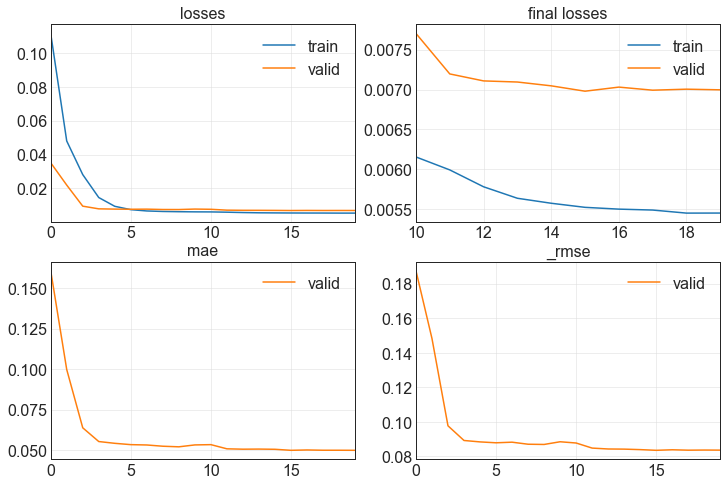

13.660507917404175                                                                                                     
[0.005451681558042765, 0.006996053270995617, 0.049912892282009125, 0.08364241570234299]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 4, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
  1%|▍                                             | 1/100 [00:17<27:45, 16.82s/trial, best loss: 0.006996053270995617]

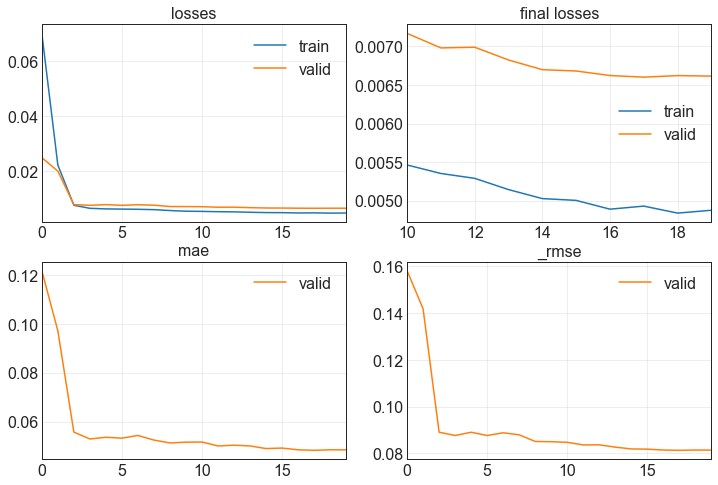

72.99261140823364                                                                                                      
[0.0048760781064629555, 0.006614881567656994, 0.04838242009282112, 0.08133191615343094]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
  2%|▉                                             | 2/100 [01:32<55:33, 34.02s/trial, best loss: 0.006614881567656994]

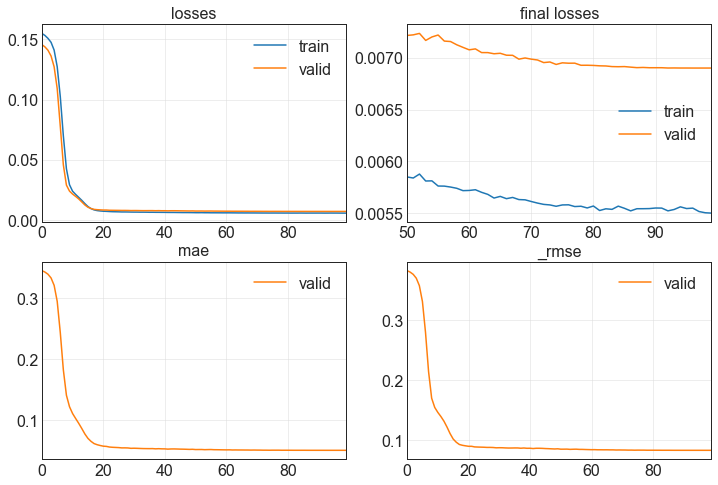

80.01683759689331                                                                                                      
[0.005501891486346722, 0.006900346372276545, 0.04978978633880615, 0.08306832611560822]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'epochs': 50, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 4, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
  3%|█▎                                          | 3/100 [02:53<1:17:50, 48.15s/trial, best loss: 0.006614881567656994]

No improvement since epoch 22: early stopping                                                                          
  3%|█▎                                          | 3/100 [03:10<1:17:50, 48.15s/trial, best loss: 0.006614881567656994]

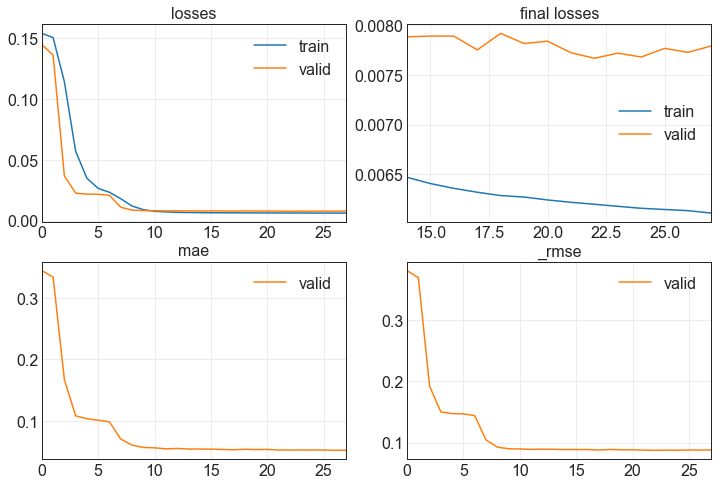

17.495620250701904                                                                                                     
[0.006111018359661102, 0.007791407406330109, 0.05237404257059097, 0.08826894313097]                                    
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 3, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
  4%|█▊                                          | 4/100 [03:11<1:02:51, 39.29s/trial, best loss: 0.006614881567656994]

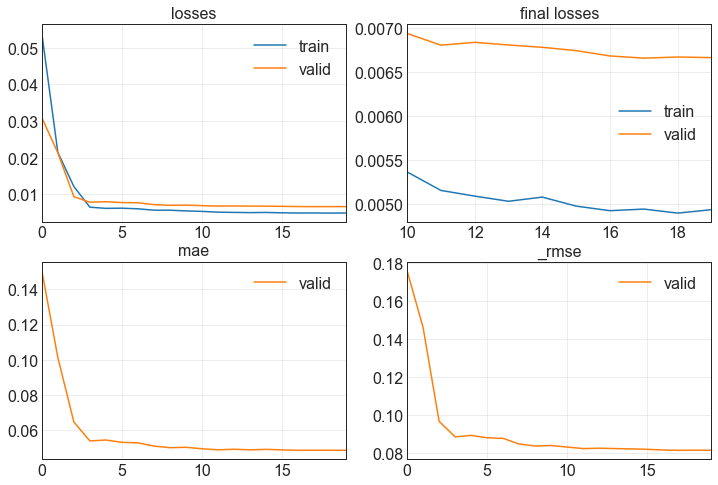

92.6633780002594                                                                                                       
[0.004938192665576935, 0.006668493151664734, 0.048746731132268906, 0.08166085183620453]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 2, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
  5%|██▏                                         | 5/100 [04:45<1:28:04, 55.63s/trial, best loss: 0.006614881567656994]

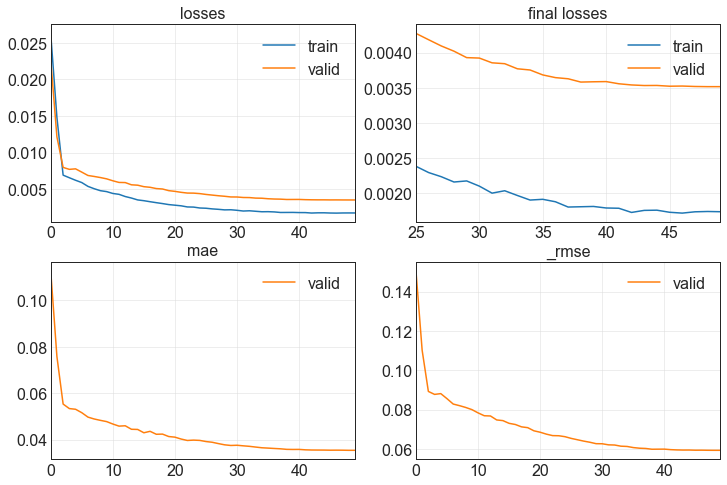

219.62963962554932                                                                                                     
[0.0017410662258043885, 0.0035172621719539165, 0.03541383892297745, 0.05930650606751442]                               
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'epochs': 50, 'hidden_size': 50, 'lr': 0.0001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
  6%|██▌                                       | 6/100 [08:26<2:44:45, 105.16s/trial, best loss: 0.0035172621719539165]

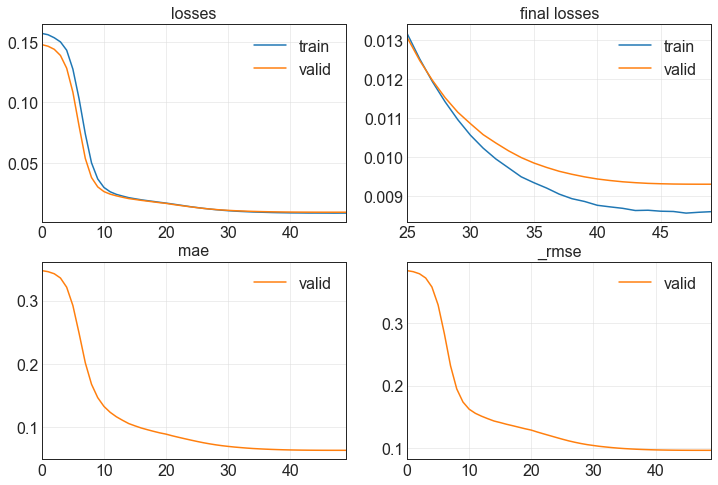

31.26937222480774                                                                                                      
[0.008603319525718689, 0.009305219165980816, 0.0638430193066597, 0.09646356850862503]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 5, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
  7%|███                                        | 7/100 [08:58<2:09:11, 83.35s/trial, best loss: 0.0035172621719539165]

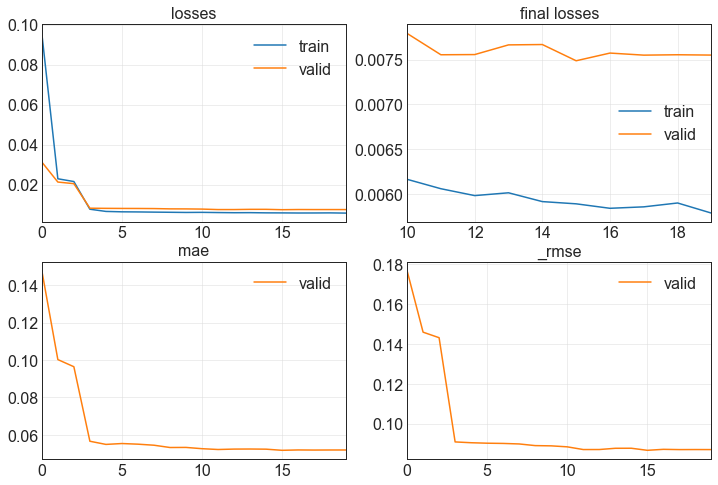

54.10890293121338                                                                                                      
[0.005784460809081793, 0.007549974601715803, 0.05185011029243469, 0.08689059317111969]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 100, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 2, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
  8%|███▍                                       | 8/100 [09:54<1:54:53, 74.92s/trial, best loss: 0.0035172621719539165]

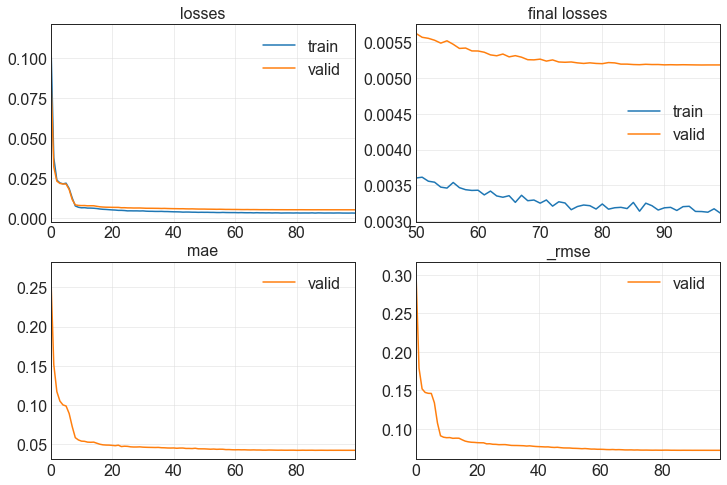

285.02881622314453                                                                                                     
[0.003112098900601268, 0.005184972193092108, 0.04255940392613411, 0.07200674712657928]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 50, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 5, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
  9%|███▊                                      | 9/100 [14:40<3:29:45, 138.30s/trial, best loss: 0.0035172621719539165]

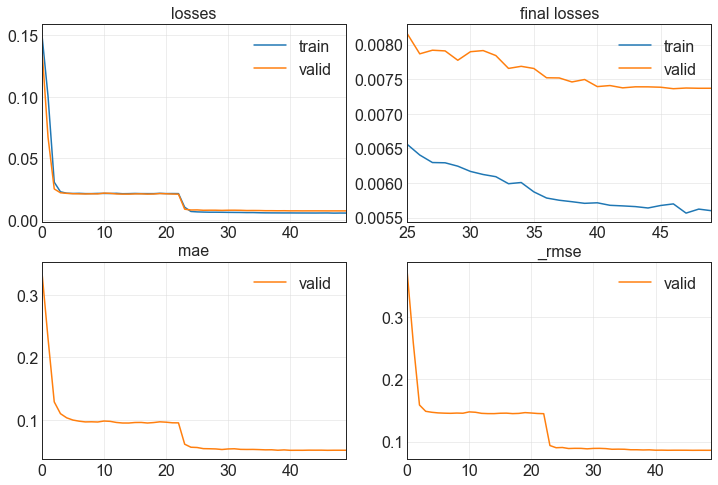

103.92804384231567                                                                                                     
[0.005599227733910084, 0.007370111532509327, 0.05137383192777634, 0.0858493447303772]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.0001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
 10%|████                                     | 10/100 [16:25<3:12:32, 128.36s/trial, best loss: 0.0035172621719539165]

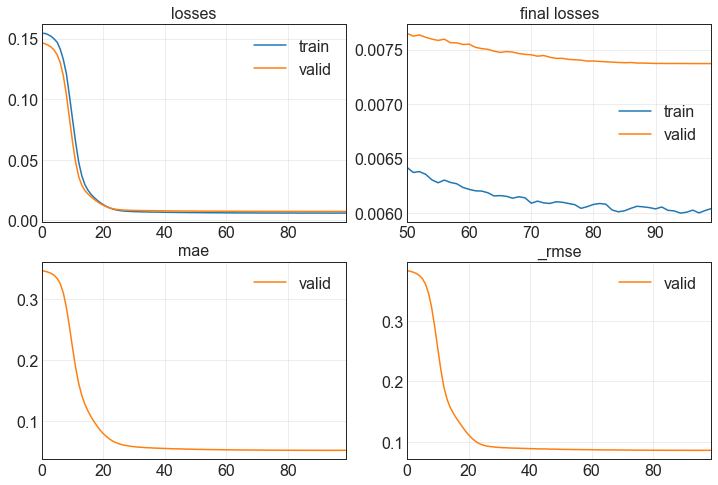

71.37912225723267                                                                                                      
[0.006039934232831001, 0.007370783481746912, 0.05199301987886429, 0.08585326373577118]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 50, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
 11%|████▌                                    | 11/100 [17:37<2:45:33, 111.62s/trial, best loss: 0.0035172621719539165]

No improvement since epoch 16: early stopping                                                                          
 11%|████▌                                    | 11/100 [19:17<2:45:33, 111.62s/trial, best loss: 0.0035172621719539165]

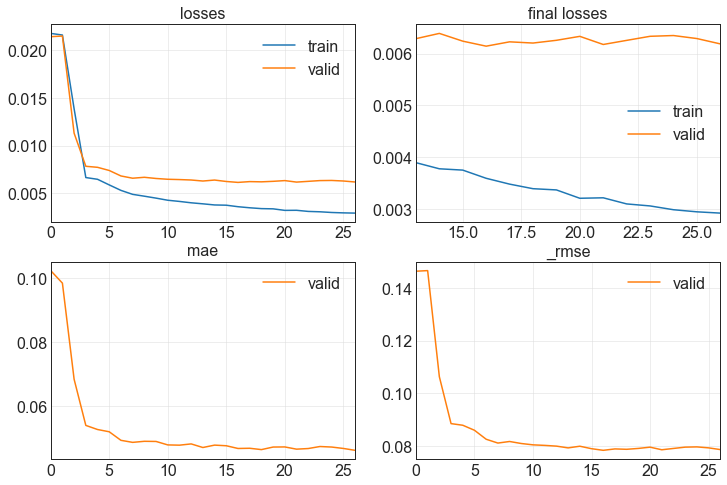

99.79322123527527                                                                                                      
[0.0029207393527030945, 0.006185606587678194, 0.046167775988578796, 0.0786486268043518]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
 12%|████▉                                    | 12/100 [19:18<2:38:59, 108.41s/trial, best loss: 0.0035172621719539165]

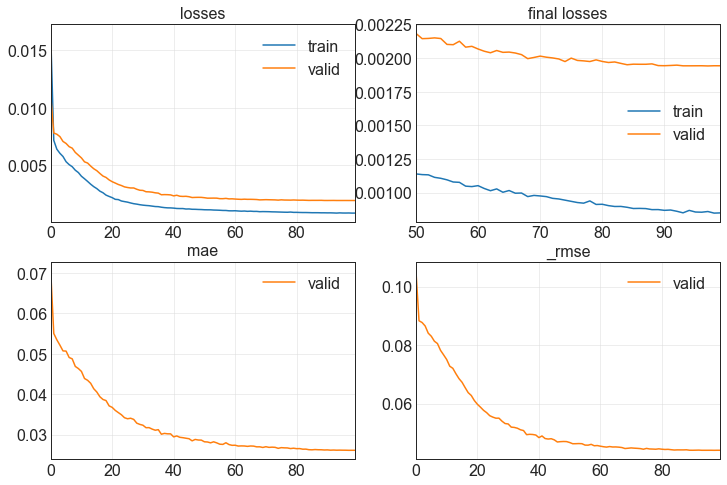

121.81218910217285                                                                                                     
[0.0008484060526825488, 0.0019433095585554838, 0.026144664734601974, 0.04408298432826996]                              
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 5, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 13%|█████▎                                   | 13/100 [21:21<2:43:31, 112.77s/trial, best loss: 0.0019433095585554838]

No improvement since epoch 26: early stopping                                                                          
 13%|█████▎                                   | 13/100 [22:30<2:43:31, 112.77s/trial, best loss: 0.0019433095585554838]

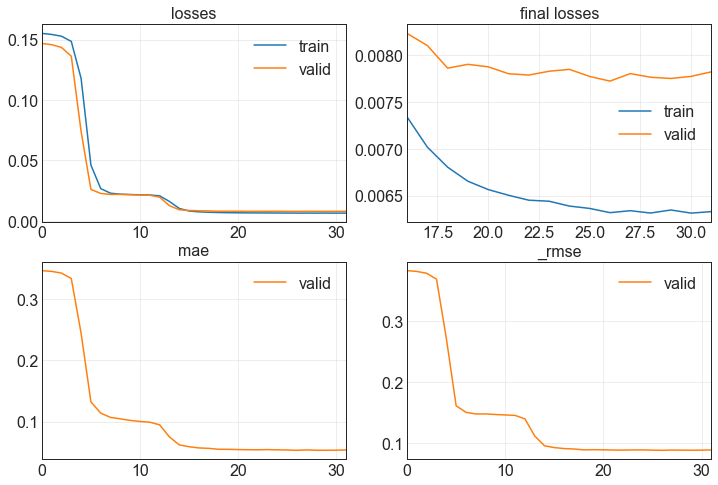

68.65406847000122                                                                                                      
[0.006329871714115143, 0.007823669351637363, 0.053514476865530014, 0.08845151215791702]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 20, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
 14%|█████▉                                    | 14/100 [22:31<2:23:11, 99.90s/trial, best loss: 0.0019433095585554838]

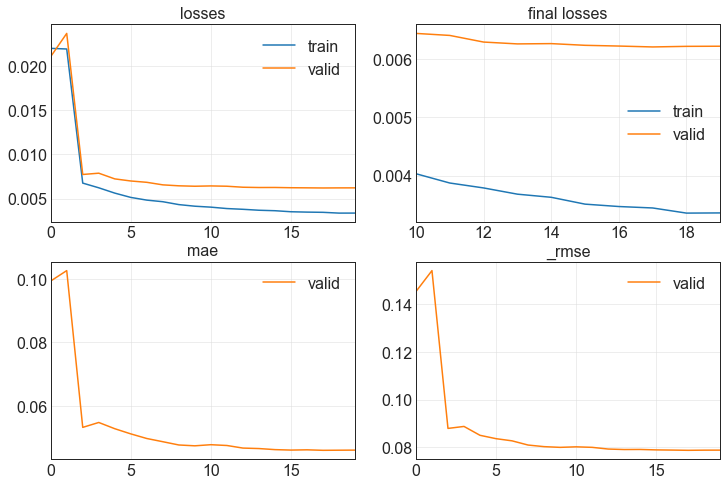

73.9013319015503                                                                                                       
[0.0033628197852522135, 0.006216493900865316, 0.046048104763031006, 0.07884476333856583]                               
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 15%|██████▎                                   | 15/100 [23:46<2:10:57, 92.44s/trial, best loss: 0.0019433095585554838]

No improvement since epoch 47: early stopping                                                                          
 15%|██████▎                                   | 15/100 [24:59<2:10:57, 92.44s/trial, best loss: 0.0019433095585554838]

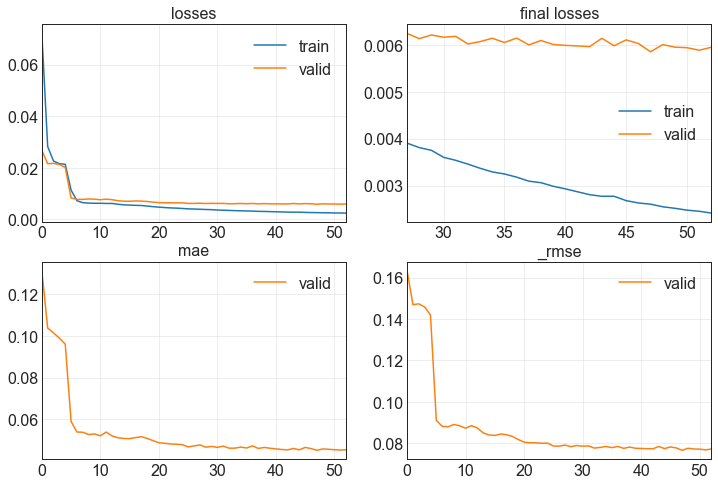

73.23220944404602                                                                                                      
[0.0024123885668814182, 0.005952377803623676, 0.04536348581314087, 0.07715165615081787]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'epochs': 50, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 5, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
 16%|██████▋                                   | 16/100 [25:01<2:01:49, 87.02s/trial, best loss: 0.0019433095585554838]

No improvement since epoch 15: early stopping                                                                          
 16%|██████▋                                   | 16/100 [25:27<2:01:49, 87.02s/trial, best loss: 0.0019433095585554838]

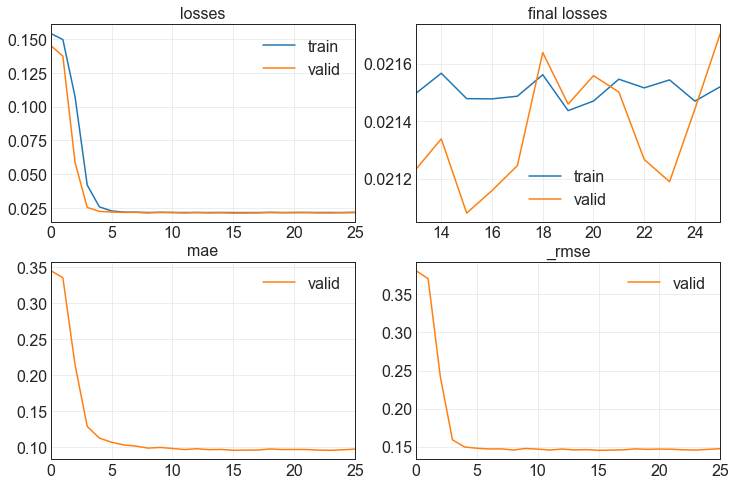

26.723334789276123                                                                                                     
[0.02151997573673725, 0.02170552872121334, 0.09778652340173721, 0.1473279744386673]                                    
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 2, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 17%|███████▏                                  | 17/100 [25:28<1:35:49, 69.27s/trial, best loss: 0.0019433095585554838]

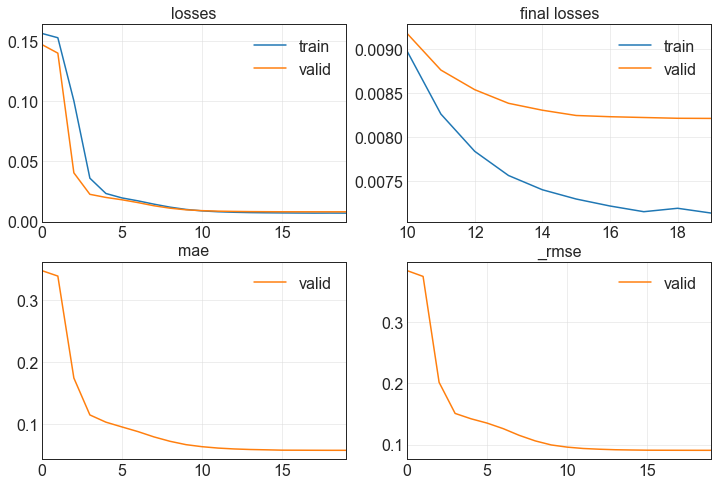

16.634379148483276                                                                                                     
[0.007141172420233488, 0.008215882815420628, 0.05788577347993851, 0.09064150601625443]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
 18%|███████▌                                  | 18/100 [25:46<1:13:33, 53.82s/trial, best loss: 0.0019433095585554838]

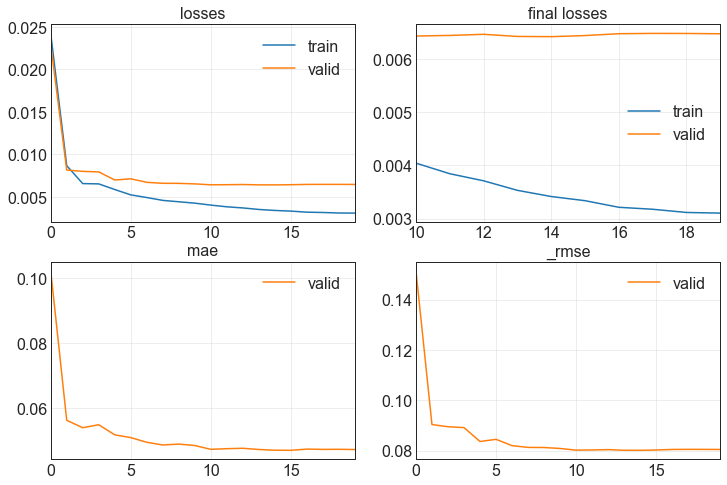

43.70679807662964                                                                                                      
[0.0031016694847494364, 0.006473717745393515, 0.04733617231249809, 0.08045943081378937]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 19%|███████▉                                  | 19/100 [26:31<1:09:01, 51.13s/trial, best loss: 0.0019433095585554838]

No improvement since epoch 15: early stopping                                                                          
 19%|███████▉                                  | 19/100 [28:30<1:09:01, 51.13s/trial, best loss: 0.0019433095585554838]

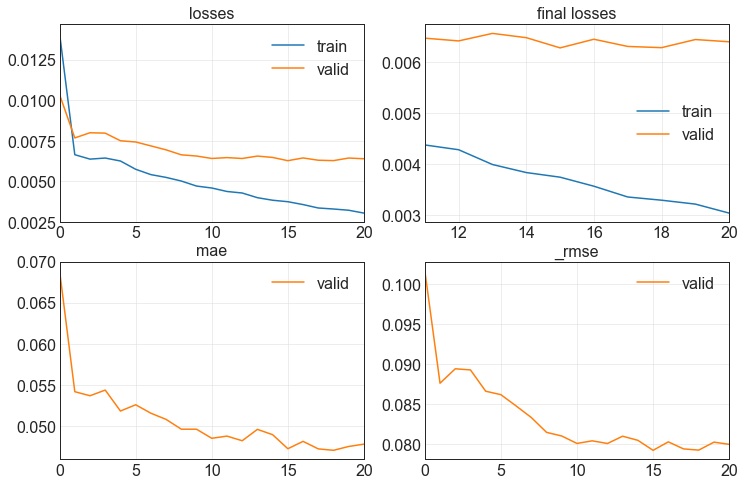

119.61827325820923                                                                                                     
[0.0030456790700554848, 0.006394375115633011, 0.04776780679821968, 0.07996483892202377]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
 20%|████████▍                                 | 20/100 [28:32<1:36:01, 72.02s/trial, best loss: 0.0019433095585554838]

No improvement since epoch 72: early stopping                                                                          
 20%|████████▍                                 | 20/100 [31:06<1:36:01, 72.02s/trial, best loss: 0.0019433095585554838]

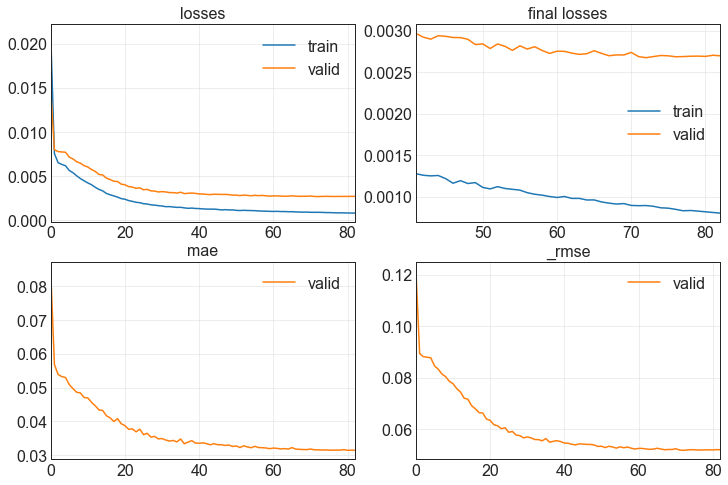

154.50738048553467                                                                                                     
[0.0008013849146664143, 0.0026959103997796774, 0.031512100249528885, 0.051922157406806946]                             
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
 21%|████████▊                                 | 21/100 [31:08<2:07:51, 97.11s/trial, best loss: 0.0019433095585554838]

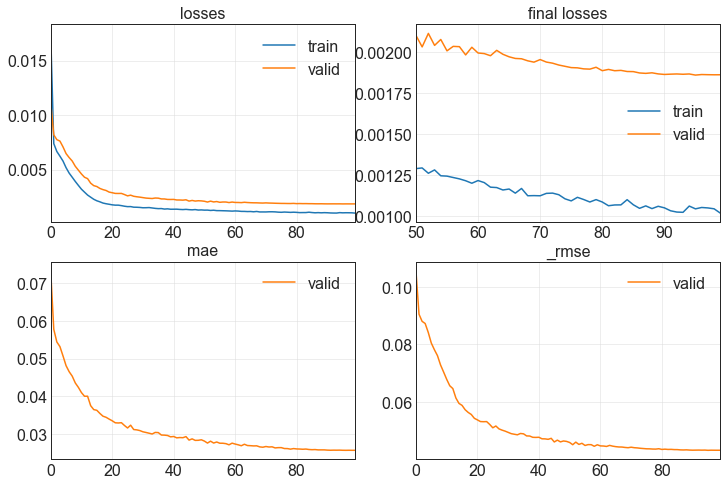

140.1572666168213                                                                                                      
[0.001018722541630268, 0.0018633969593793154, 0.025696368888020515, 0.04316708445549011]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
 22%|█████████                                | 22/100 [33:29<2:23:29, 110.38s/trial, best loss: 0.0018633969593793154]

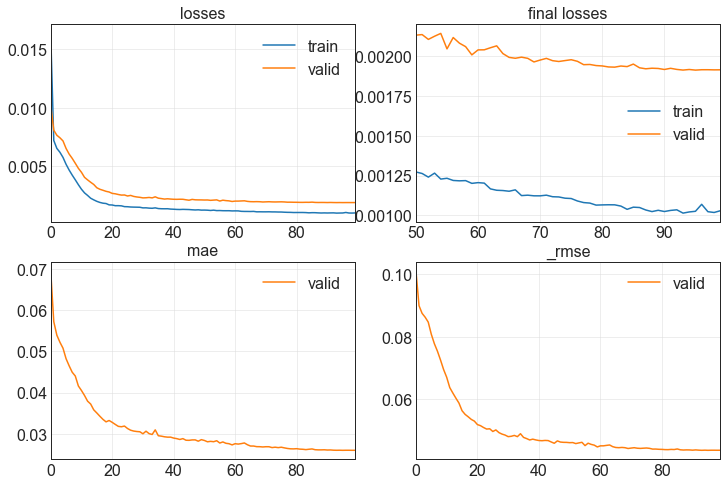

147.70073914527893                                                                                                     
[0.001029696548357606, 0.0019132292363792658, 0.025983711704611778, 0.04374047368764877]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
 23%|█████████▍                               | 23/100 [35:58<2:36:27, 121.92s/trial, best loss: 0.0018633969593793154]

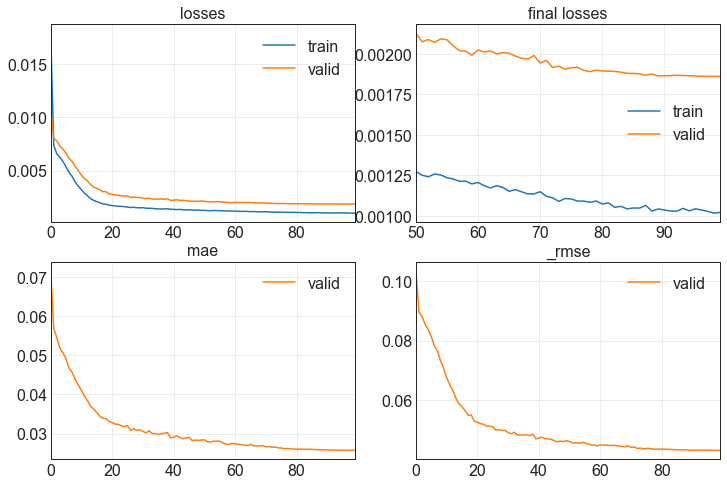

138.8177309036255                                                                                                      
[0.0010211844928562641, 0.001861424883827567, 0.02572854794561863, 0.04314423352479935]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
 24%|██████████                                | 24/100 [38:18<2:41:19, 127.36s/trial, best loss: 0.001861424883827567]

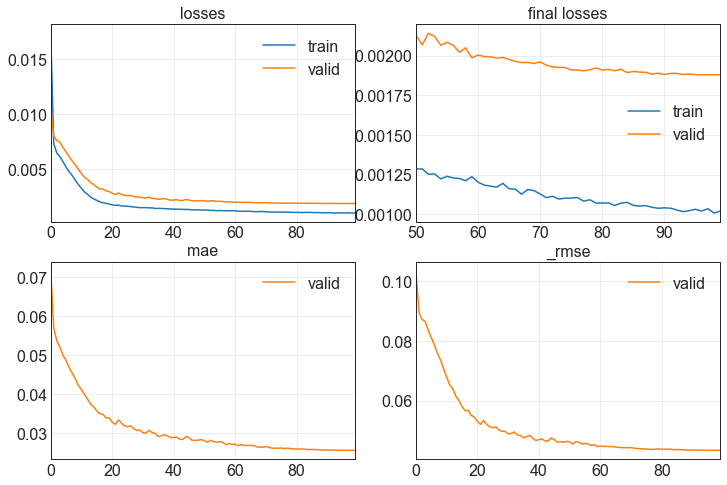

144.64437866210938                                                                                                     
[0.0010198045056313276, 0.0018798363162204623, 0.02568267285823822, 0.04335708171129227]                               
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
 25%|██████████▌                               | 25/100 [40:44<2:46:07, 132.90s/trial, best loss: 0.001861424883827567]

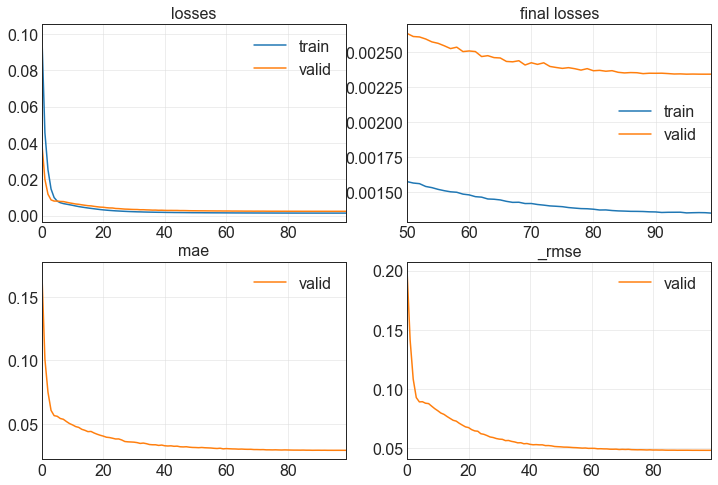

43.620718479156494                                                                                                     
[0.0013474472798407078, 0.0023397605400532484, 0.029150348156690598, 0.048371072858572006]                             
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
 26%|██████████▉                               | 26/100 [41:28<2:11:17, 106.46s/trial, best loss: 0.001861424883827567]

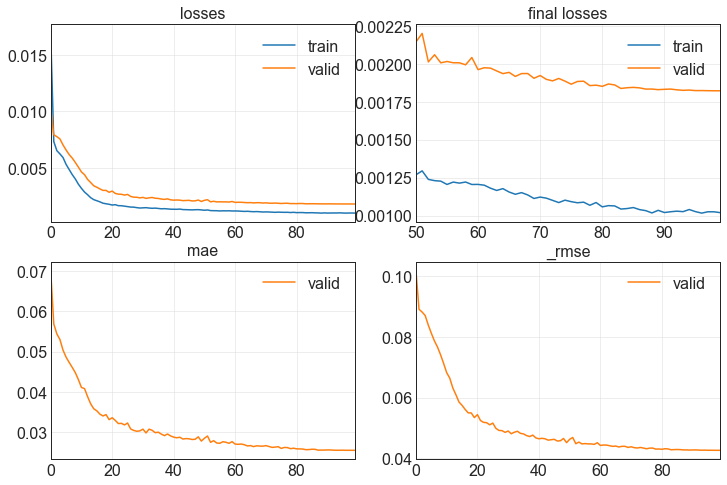

137.52795934677124                                                                                                     
[0.0010189481545239687, 0.0018222491489723325, 0.02554790861904621, 0.04268781095743179]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
 27%|███████████                              | 27/100 [43:47<2:21:16, 116.12s/trial, best loss: 0.0018222491489723325]

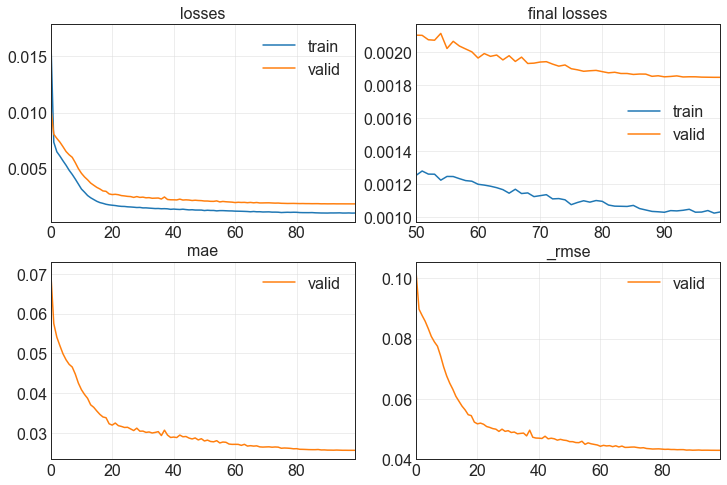

141.18939518928528                                                                                                     
[0.001029233098961413, 0.0018456850666552782, 0.02566627599298954, 0.04296143725514412]                                
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
 28%|███████████▍                             | 28/100 [46:09<2:28:47, 123.99s/trial, best loss: 0.0018222491489723325]

No improvement since epoch 89: early stopping                                                                          
 28%|███████████▍                             | 28/100 [47:27<2:28:47, 123.99s/trial, best loss: 0.0018222491489723325]

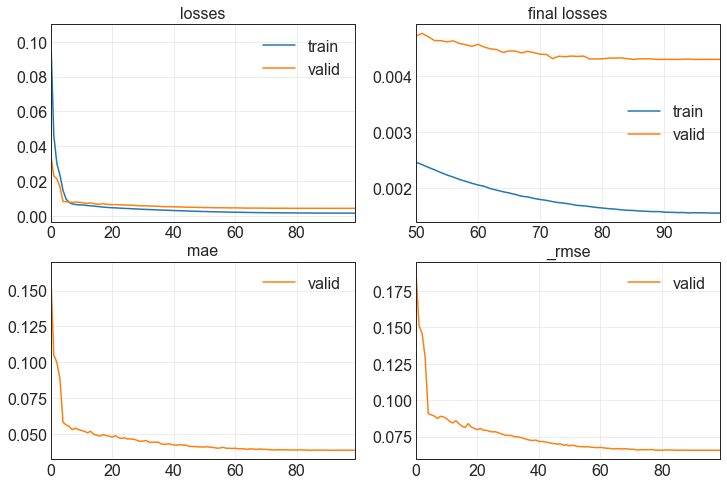

77.99576115608215                                                                                                      
[0.0015522611793130636, 0.004295455291867256, 0.03877575695514679, 0.06553972512483597]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
 29%|███████████▉                             | 29/100 [47:29<2:10:48, 110.54s/trial, best loss: 0.0018222491489723325]

No improvement since epoch 59: early stopping                                                                          
 29%|███████████▉                             | 29/100 [50:16<2:10:48, 110.54s/trial, best loss: 0.0018222491489723325]

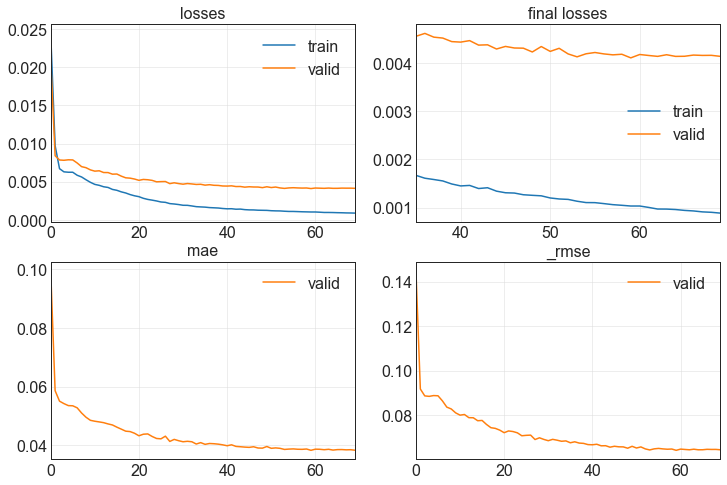

168.33263635635376                                                                                                     
[0.0008884373819455504, 0.004134366754442453, 0.03827228397130966, 0.06429903954267502]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
 30%|████████████▎                            | 30/100 [50:18<2:29:36, 128.24s/trial, best loss: 0.0018222491489723325]

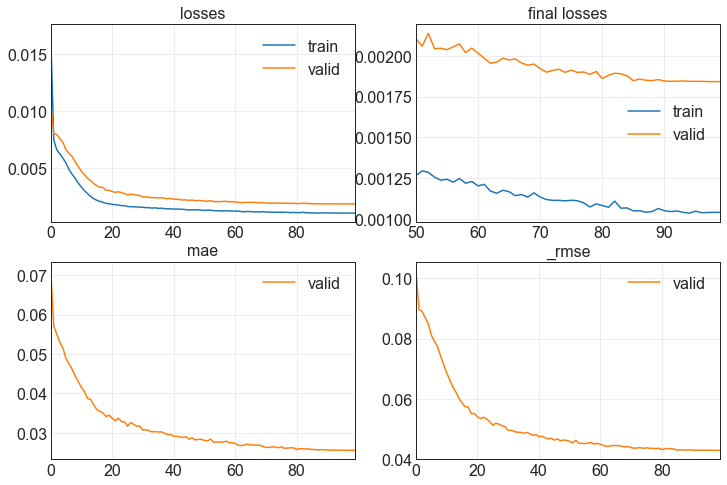

138.08243775367737                                                                                                     
[0.0010398911545053124, 0.0018421581480652094, 0.025561749935150146, 0.042920369654893875]                             
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
 31%|████████████▋                            | 31/100 [52:37<2:31:19, 131.58s/trial, best loss: 0.0018222491489723325]

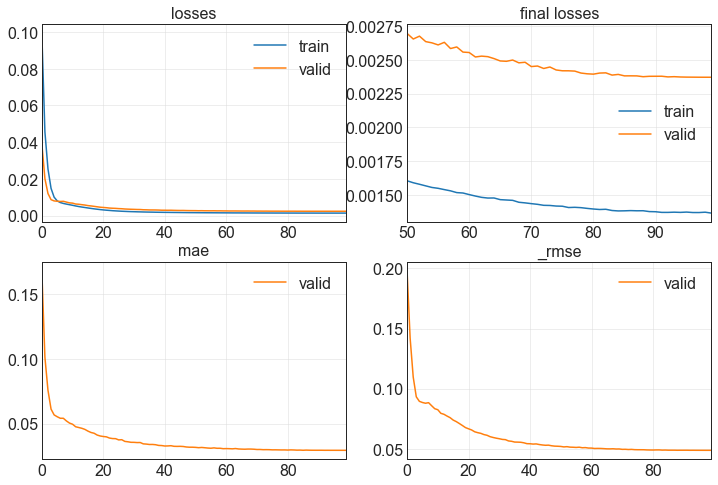

43.657923460006714                                                                                                     
[0.0013642236590385437, 0.002371210604906082, 0.029369039461016655, 0.04869507625699043]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.0001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
 32%|█████████████                            | 32/100 [53:22<1:59:38, 105.56s/trial, best loss: 0.0018222491489723325]

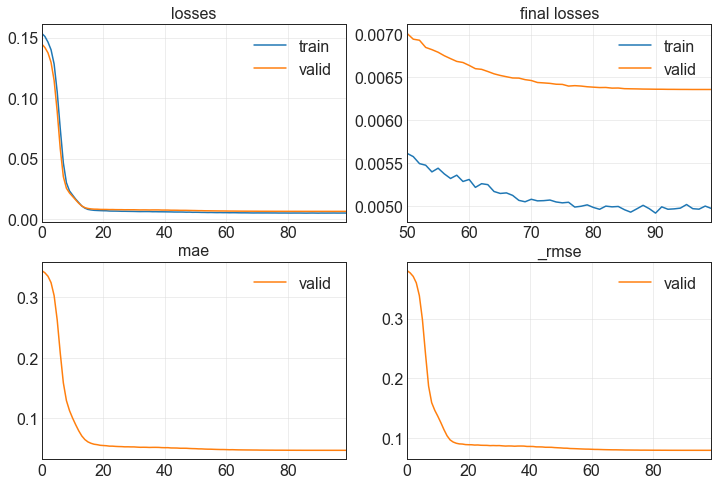

135.89440631866455                                                                                                     
[0.004970442969352007, 0.0063592842780053616, 0.047343745827674866, 0.07974512130022049]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
 33%|█████████████▌                           | 33/100 [55:39<2:08:25, 115.00s/trial, best loss: 0.0018222491489723325]

No improvement since epoch 67: early stopping                                                                          
 33%|█████████████▌                           | 33/100 [58:43<2:08:25, 115.00s/trial, best loss: 0.0018222491489723325]

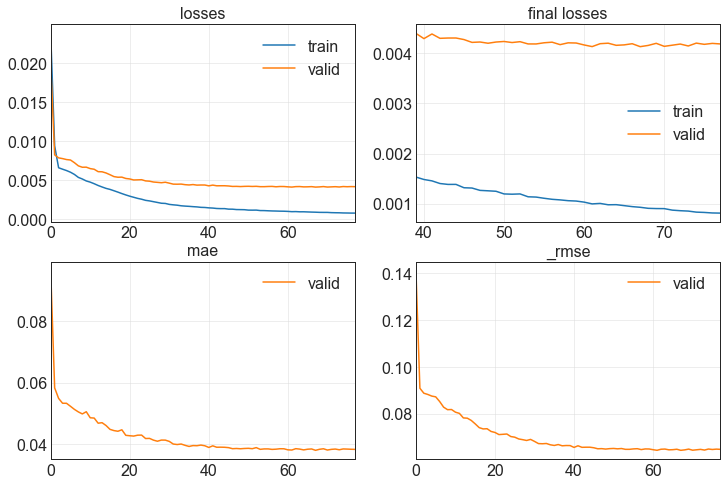

183.87881517410278                                                                                                     
[0.0008088378817774355, 0.004190260078758001, 0.038237836211919785, 0.06473222374916077]                               
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
 34%|█████████████▉                           | 34/100 [58:44<2:29:37, 136.02s/trial, best loss: 0.0018222491489723325]

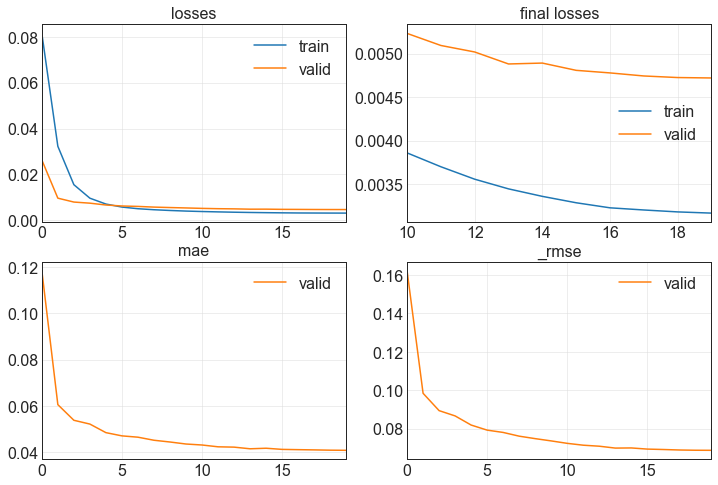

9.622289419174194                                                                                                      
[0.0031684061978012323, 0.004719457123428583, 0.04079294949769974, 0.06869830191135406]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.0001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 35%|██████████████▋                           | 35/100 [58:55<1:46:38, 98.45s/trial, best loss: 0.0018222491489723325]

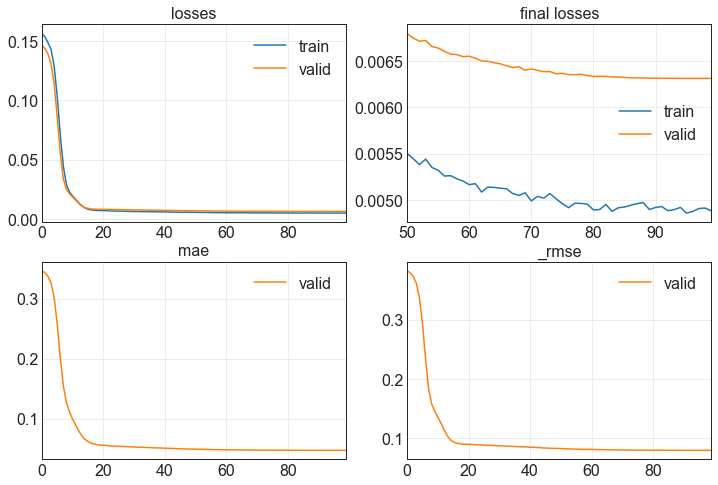

144.04883456230164                                                                                                     
[0.004879745654761791, 0.00631396658718586, 0.047223322093486786, 0.07946047186851501]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
 36%|██████████████                         | 36/100 [1:01:20<1:59:57, 112.47s/trial, best loss: 0.0018222491489723325]

No improvement since epoch 56: early stopping                                                                          
 36%|██████████████                         | 36/100 [1:03:54<1:59:57, 112.47s/trial, best loss: 0.0018222491489723325]

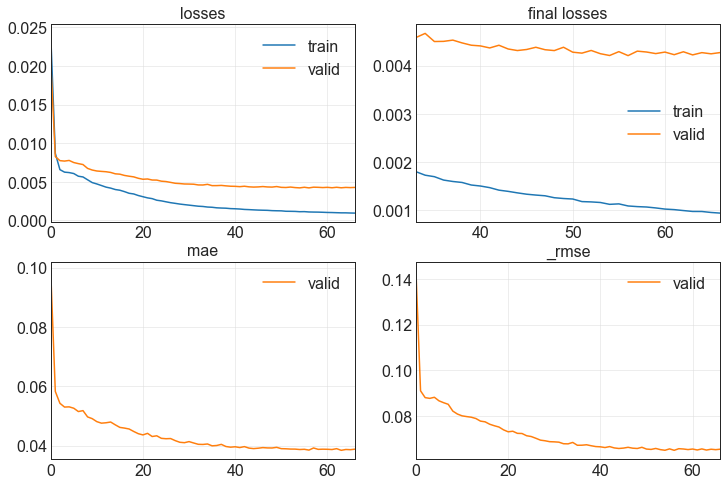

154.09441566467285                                                                                                     
[0.0009403238072991371, 0.004270210396498442, 0.038771744817495346, 0.0653468519449234]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 2, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
 37%|██████████████▍                        | 37/100 [1:03:56<2:11:34, 125.31s/trial, best loss: 0.0018222491489723325]

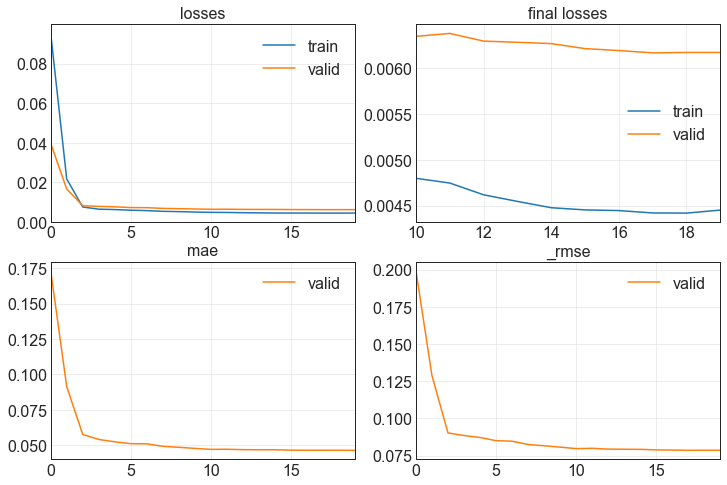

38.27099871635437                                                                                                      
[0.004450654610991478, 0.006172826513648033, 0.0463704876601696, 0.07856734097003937]                                  
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 50, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 5, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 38%|███████████████▏                        | 38/100 [1:04:35<1:42:51, 99.54s/trial, best loss: 0.0018222491489723325]

No improvement since epoch 6: early stopping                                                                           
 38%|███████████████▏                        | 38/100 [1:04:48<1:42:51, 99.54s/trial, best loss: 0.0018222491489723325]

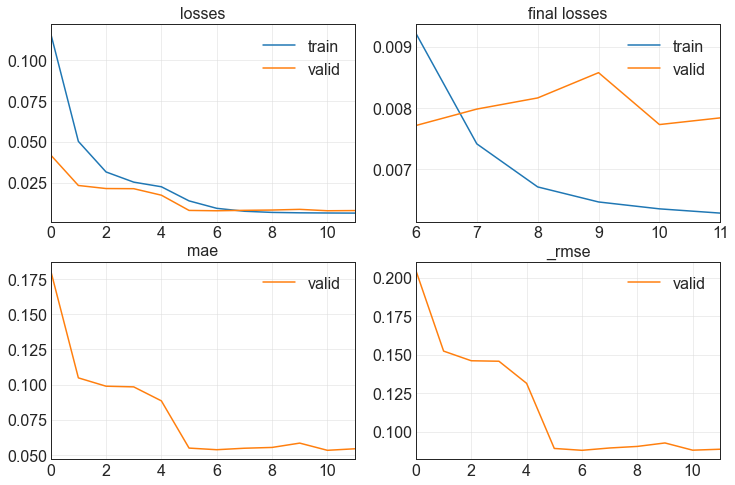

13.391001224517822                                                                                                     
[0.0062821367755532265, 0.007837599143385887, 0.0543338917195797, 0.08853021264076233]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
 39%|███████████████▌                        | 39/100 [1:04:50<1:15:17, 74.06s/trial, best loss: 0.0018222491489723325]

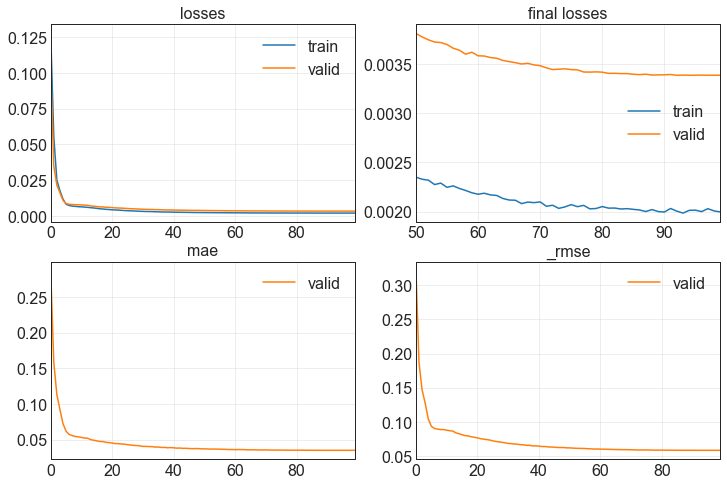

140.27478623390198                                                                                                     
[0.001997812418267131, 0.0033862849231809378, 0.034938979893922806, 0.05819179490208626]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
 40%|████████████████                        | 40/100 [1:07:11<1:34:15, 94.26s/trial, best loss: 0.0018222491489723325]

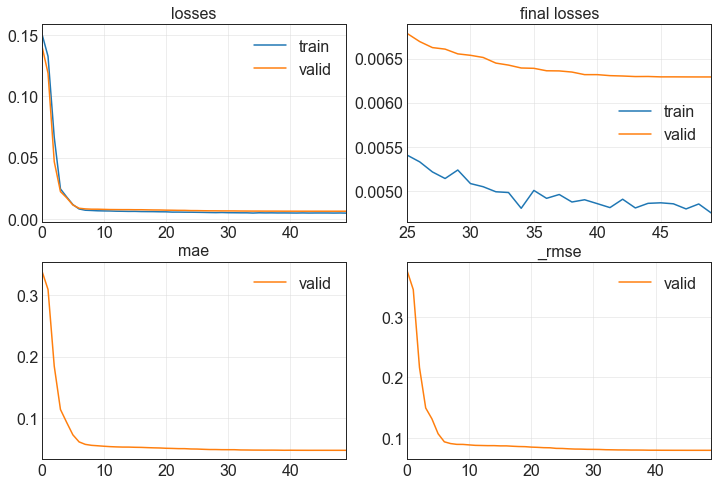

158.2549340724945                                                                                                      
[0.004749280866235495, 0.006291436031460762, 0.04712994396686554, 0.0793185755610466]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
 41%|███████████████▉                       | 41/100 [1:09:51<1:51:55, 113.83s/trial, best loss: 0.0018222491489723325]

No improvement since epoch 73: early stopping                                                                          
 41%|███████████████▉                       | 41/100 [1:12:31<1:51:55, 113.83s/trial, best loss: 0.0018222491489723325]

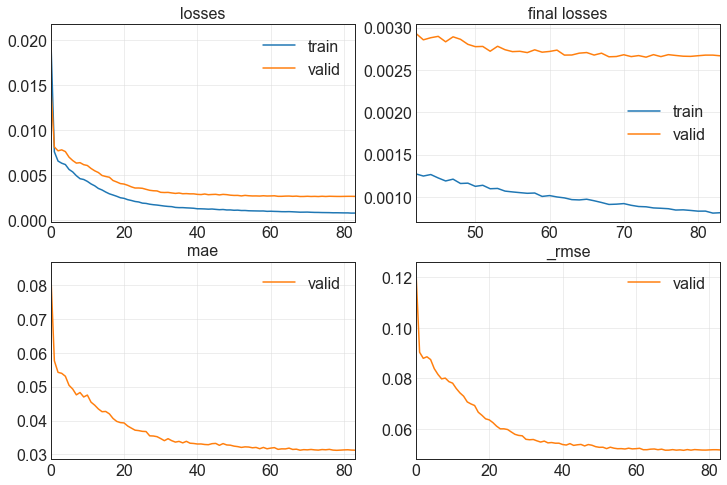

161.22670149803162                                                                                                     
[0.0008143149316310883, 0.002667087595909834, 0.03123708814382553, 0.05164385586977005]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 42%|████████████████▍                      | 42/100 [1:12:33<2:04:09, 128.45s/trial, best loss: 0.0018222491489723325]

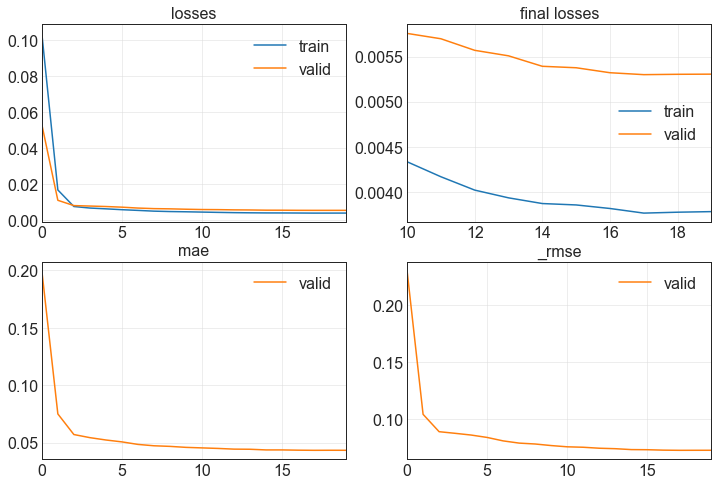

28.44018578529358                                                                                                      
[0.003781717037782073, 0.005304561462253332, 0.043240487575531006, 0.07283242791891098]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 5, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
 43%|█████████████████▏                      | 43/100 [1:13:03<1:33:51, 98.80s/trial, best loss: 0.0018222491489723325]

No improvement since epoch 48: early stopping                                                                          
 43%|█████████████████▏                      | 43/100 [1:18:01<1:33:51, 98.80s/trial, best loss: 0.0018222491489723325]

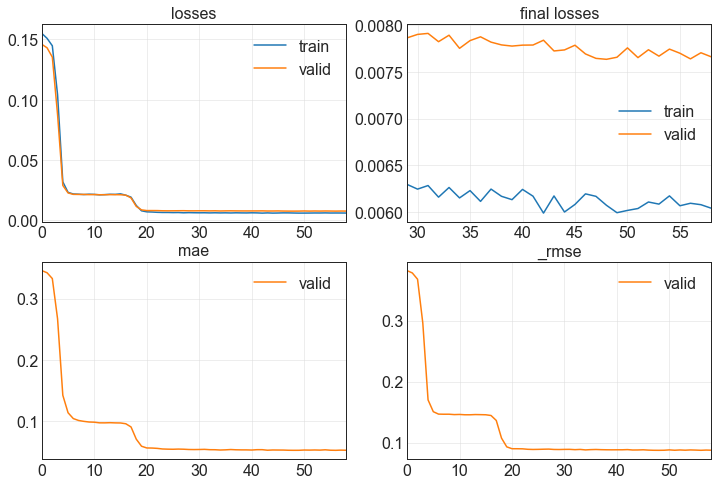

298.44833064079285                                                                                                     
[0.006038879510015249, 0.007661201059818268, 0.0521567277610302, 0.0875282809138298]                                   
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
 44%|█████████████████▏                     | 44/100 [1:18:03<2:28:27, 159.05s/trial, best loss: 0.0018222491489723325]

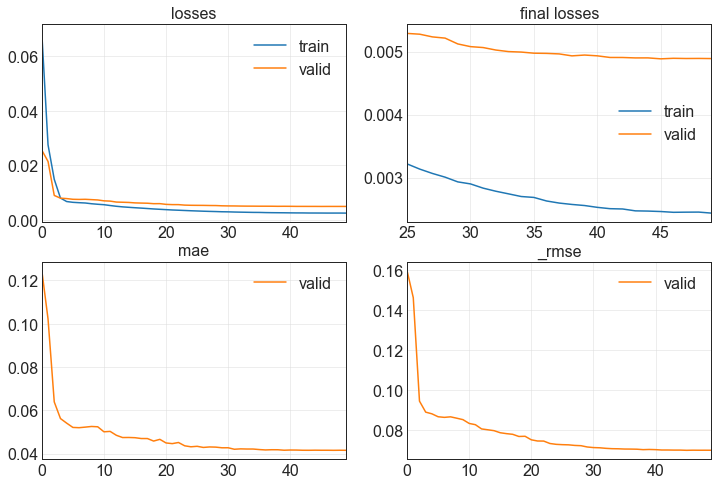

59.91836977005005                                                                                                      
[0.0024370127357542515, 0.004888999275863171, 0.04152366891503334, 0.06992138177156448]                                
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 45%|█████████████████▌                     | 45/100 [1:19:04<1:58:55, 129.73s/trial, best loss: 0.0018222491489723325]

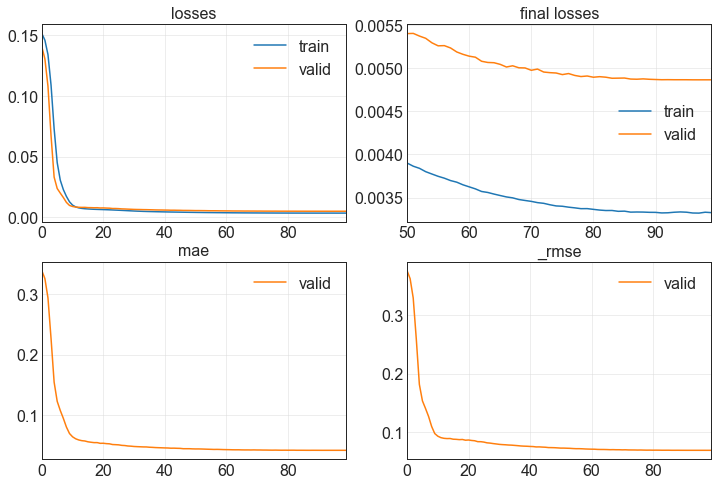

44.87951135635376                                                                                                      
[0.003326243022456765, 0.004863211885094643, 0.041220325976610184, 0.06973672658205032]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 20, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
 46%|█████████████████▉                     | 46/100 [1:19:50<1:34:09, 104.62s/trial, best loss: 0.0018222491489723325]

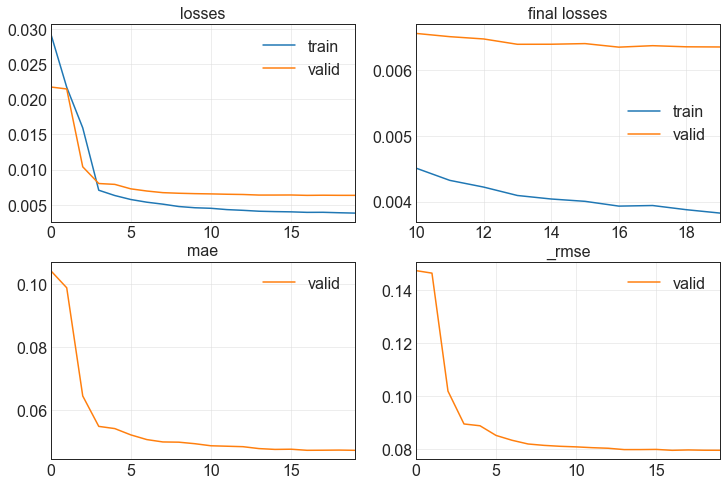

36.62854719161987                                                                                                      
[0.0038268559146672487, 0.006349165458232164, 0.047109294682741165, 0.07968165725469589]                               
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
 47%|██████████████████▊                     | 47/100 [1:20:27<1:14:42, 84.57s/trial, best loss: 0.0018222491489723325]

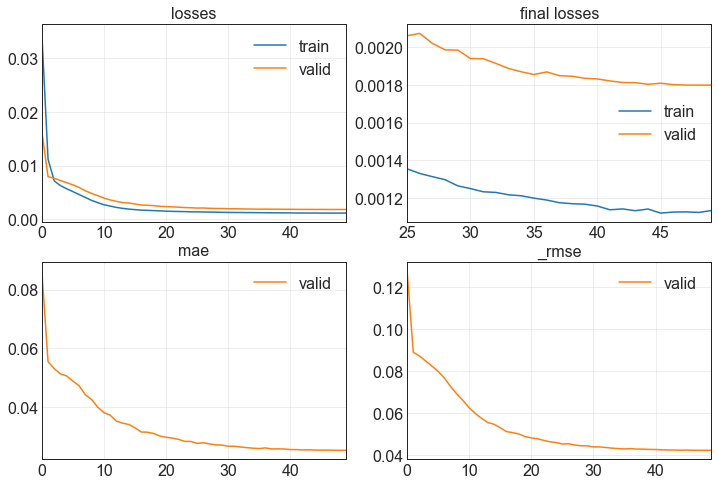

43.63721513748169                                                                                                      
[0.0011338201584294438, 0.0017981758574023843, 0.025163689628243446, 0.042404904961586]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'epochs': 50, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 5, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 48%|███████████████████▏                    | 48/100 [1:21:12<1:02:57, 72.64s/trial, best loss: 0.0017981758574023843]

No improvement since epoch 13: early stopping                                                                          
 48%|███████████████████▏                    | 48/100 [1:21:38<1:02:57, 72.64s/trial, best loss: 0.0017981758574023843]

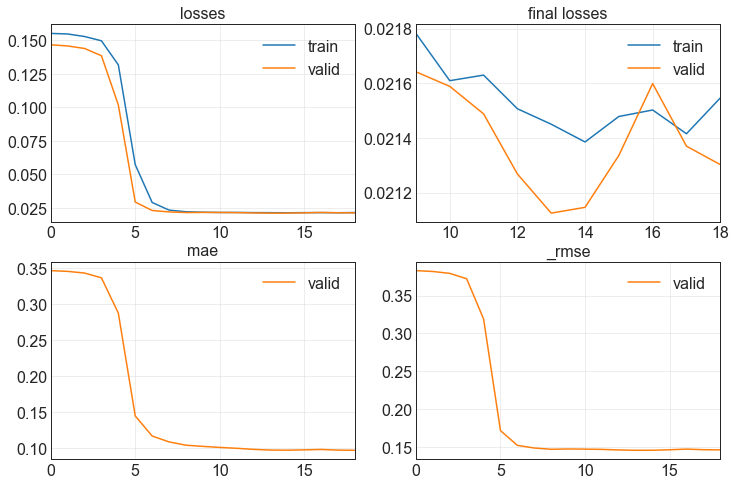

26.25789737701416                                                                                                      
[0.021546315401792526, 0.02130243368446827, 0.09747353941202164, 0.14595353603363037]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 2, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
 49%|████████████████████▌                     | 49/100 [1:21:40<50:12, 59.07s/trial, best loss: 0.0017981758574023843]

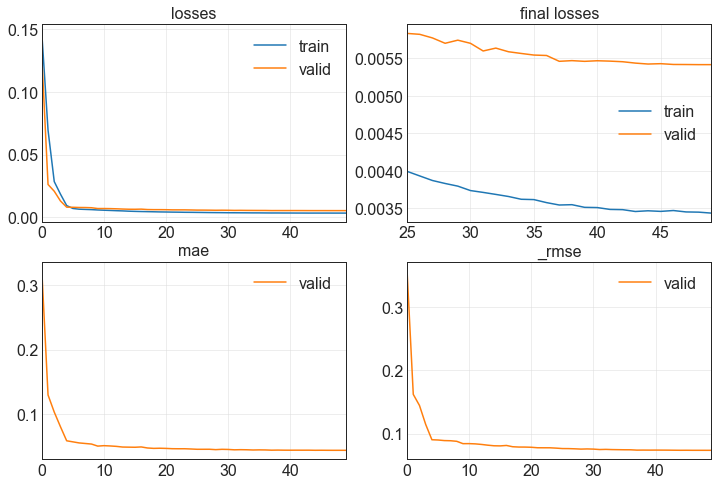

58.401604652404785                                                                                                     
[0.0034353816881775856, 0.005417645908892155, 0.04352318495512009, 0.07360467314720154]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 10}
LSTM                                                                                                                   
 50%|█████████████████████                     | 50/100 [1:22:39<49:21, 59.22s/trial, best loss: 0.0017981758574023843]

No improvement since epoch 15: early stopping                                                                          
 50%|█████████████████████                     | 50/100 [1:23:09<49:21, 59.22s/trial, best loss: 0.0017981758574023843]

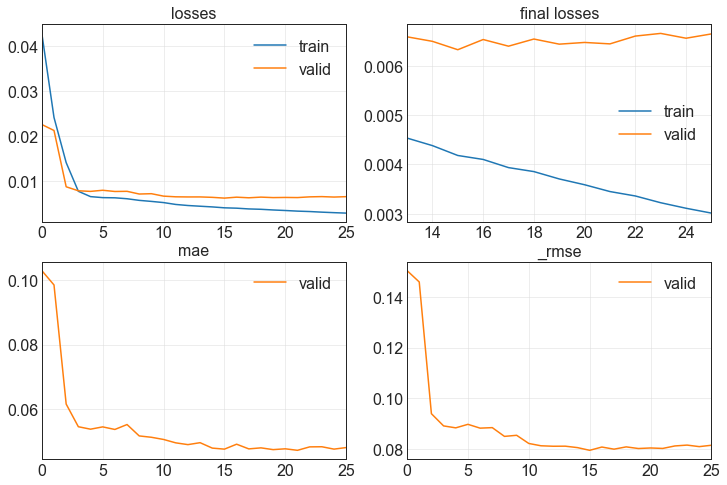

30.360999822616577                                                                                                     
[0.003013000125065446, 0.00664884177967906, 0.04800500348210335, 0.08154043555259705]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 51%|█████████████████████▍                    | 51/100 [1:23:11<41:34, 50.91s/trial, best loss: 0.0017981758574023843]

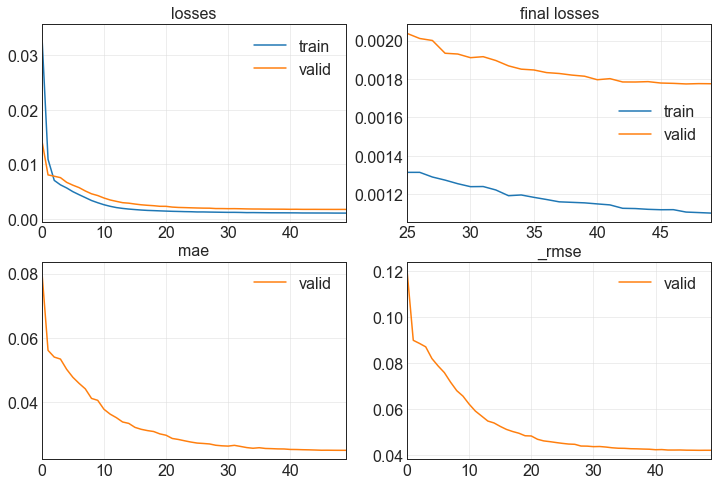

42.503570795059204                                                                                                     
[0.001101041678339243, 0.001775373239070177, 0.02499711513519287, 0.042135175317525864]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 5, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 52%|██████████████████████▎                    | 52/100 [1:23:54<39:00, 48.75s/trial, best loss: 0.001775373239070177]

No improvement since epoch 30: early stopping                                                                          
 52%|██████████████████████▎                    | 52/100 [1:25:10<39:00, 48.75s/trial, best loss: 0.001775373239070177]

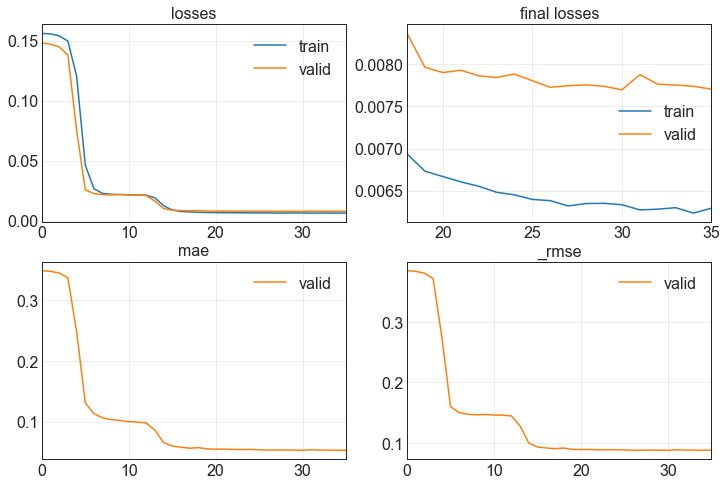

76.42713642120361                                                                                                      
[0.006292628590017557, 0.00770482886582613, 0.052756790071725845, 0.08777716755867004]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 53%|██████████████████████▊                    | 53/100 [1:25:12<44:58, 57.41s/trial, best loss: 0.001775373239070177]

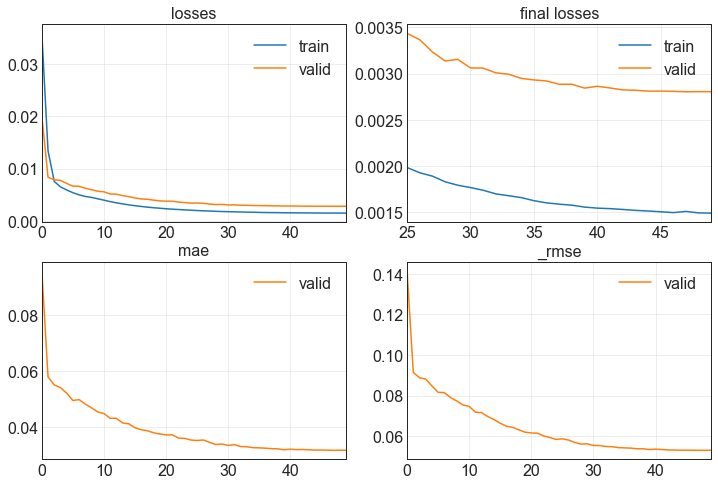

32.24752593040466                                                                                                      
[0.0014929177705198526, 0.002805146388709545, 0.03169512376189232, 0.052963629364967346]                               
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 2, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 54%|███████████████████████▏                   | 54/100 [1:25:45<38:29, 50.20s/trial, best loss: 0.001775373239070177]

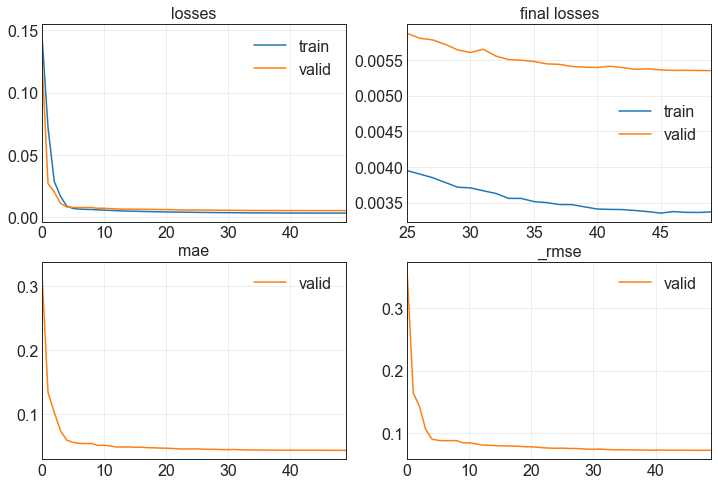

57.98156142234802                                                                                                      
[0.0033703905064612627, 0.005349453538656235, 0.04312639683485031, 0.07313995808362961]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 55%|███████████████████████▋                   | 55/100 [1:26:45<39:39, 52.88s/trial, best loss: 0.001775373239070177]

No improvement since epoch 11: early stopping                                                                          
 55%|███████████████████████▋                   | 55/100 [1:27:15<39:39, 52.88s/trial, best loss: 0.001775373239070177]

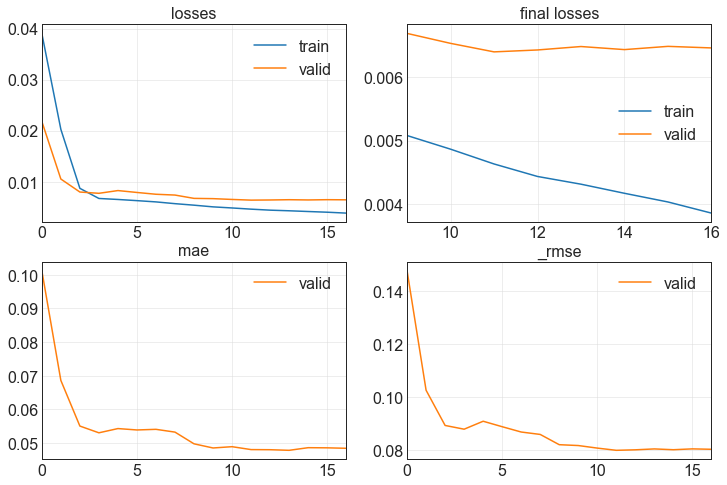

30.84514045715332                                                                                                      
[0.00385532365180552, 0.006460041273385286, 0.048481784760951996, 0.08037438243627548]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 56%|████████████████████████                   | 56/100 [1:27:17<34:11, 46.62s/trial, best loss: 0.001775373239070177]

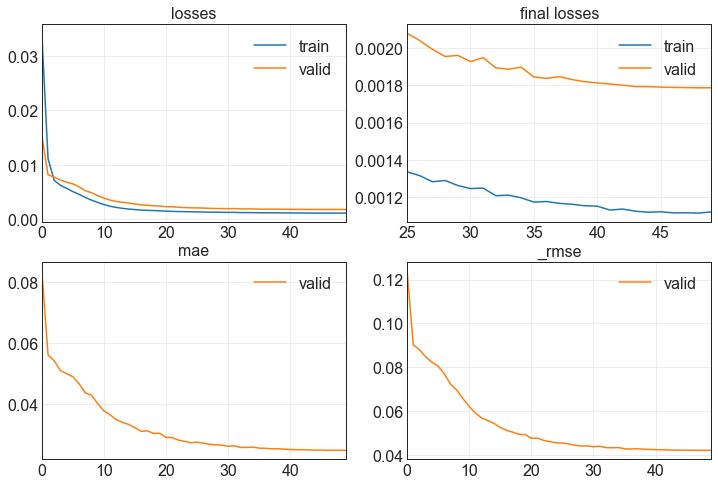

40.40569567680359                                                                                                      
[0.0011222681496292353, 0.0017864919500425458, 0.02500292658805847, 0.04226691275835037]                               
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 57%|████████████████████████▌                  | 57/100 [1:27:58<32:19, 45.10s/trial, best loss: 0.001775373239070177]

No improvement since epoch 19: early stopping                                                                          
 57%|████████████████████████▌                  | 57/100 [1:28:24<32:19, 45.10s/trial, best loss: 0.001775373239070177]

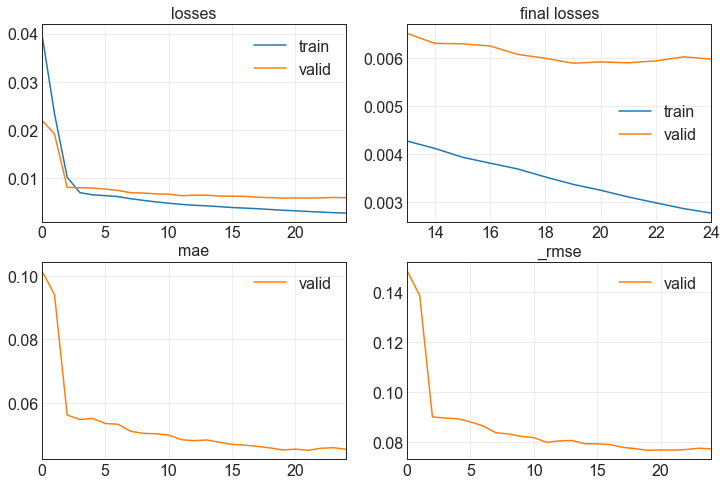

26.757078170776367                                                                                                     
[0.002776301233097911, 0.005973883904516697, 0.0454803965985775, 0.07729090750217438]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 58%|████████████████████████▉                  | 58/100 [1:28:26<27:57, 39.94s/trial, best loss: 0.001775373239070177]

No improvement since epoch 25: early stopping                                                                          
 58%|████████████████████████▉                  | 58/100 [1:28:54<27:57, 39.94s/trial, best loss: 0.001775373239070177]

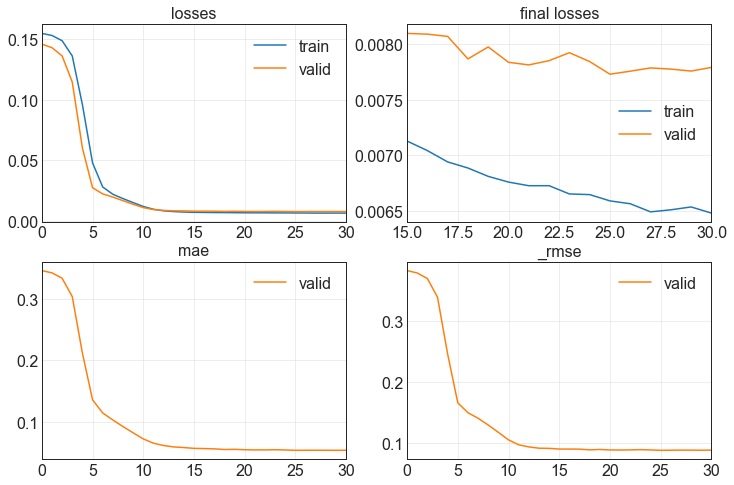

28.22868275642395                                                                                                      
[0.006480935961008072, 0.007790991570800543, 0.05372592806816101, 0.08826659619808197]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 59%|█████████████████████████▎                 | 59/100 [1:28:55<25:07, 36.76s/trial, best loss: 0.001775373239070177]

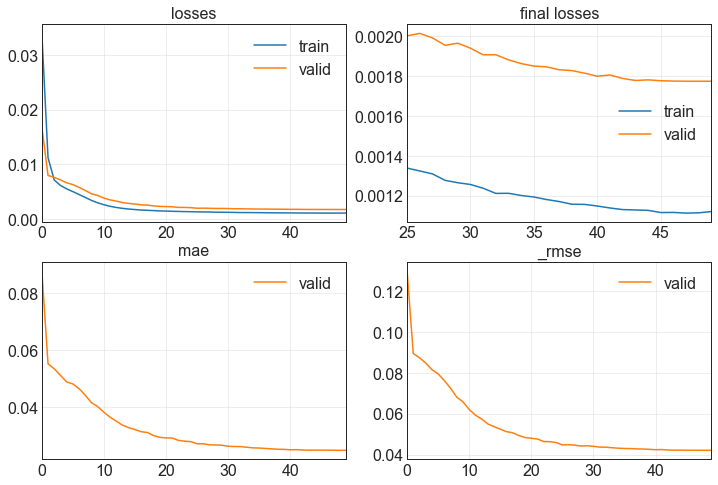

43.89953112602234                                                                                                      
[0.0011194359976798296, 0.0017745621735230088, 0.024958036839962006, 0.042125556617975235]                             
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 50, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 5, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 60%|█████████████████████████▏                | 60/100 [1:29:41<26:11, 39.28s/trial, best loss: 0.0017745621735230088]

No improvement since epoch 23: early stopping                                                                          
 60%|█████████████████████████▏                | 60/100 [1:32:05<26:11, 39.28s/trial, best loss: 0.0017745621735230088]

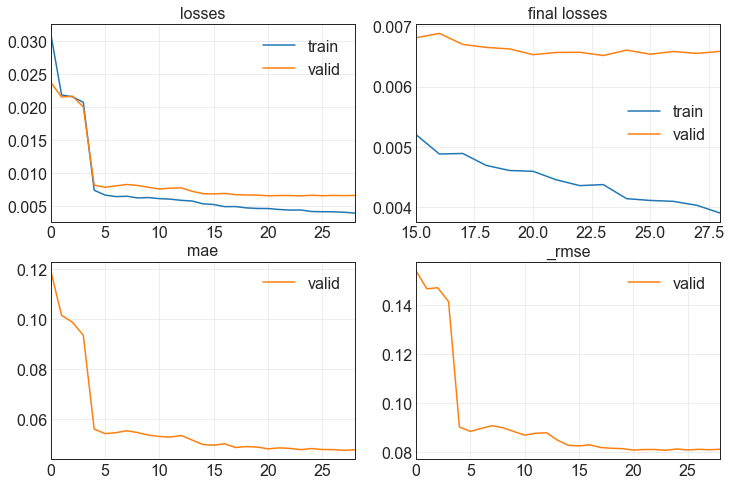

145.48619103431702                                                                                                     
[0.0039014783687889576, 0.006585423834621906, 0.04760272428393364, 0.08115062862634659]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 61%|█████████████████████████▌                | 61/100 [1:32:07<46:28, 71.49s/trial, best loss: 0.0017745621735230088]

No improvement since epoch 18: early stopping                                                                          
 61%|█████████████████████████▌                | 61/100 [1:32:53<46:28, 71.49s/trial, best loss: 0.0017745621735230088]

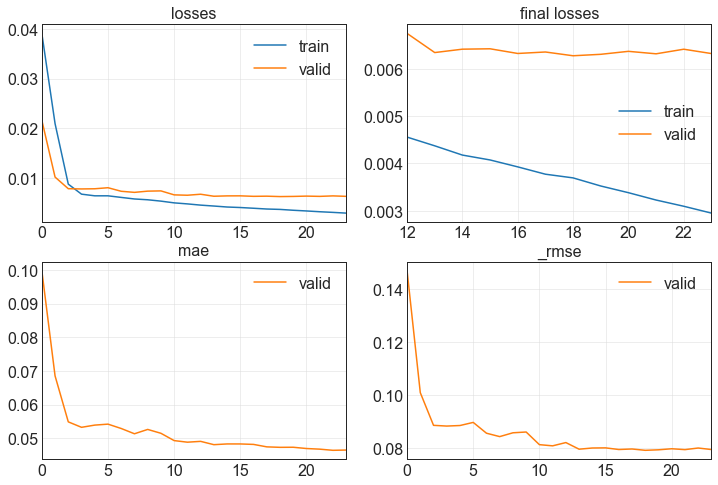

45.80556273460388                                                                                                      
[0.0029503076802939177, 0.006322947330772877, 0.04649348556995392, 0.07951696962118149]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 62%|██████████████████████████                | 62/100 [1:32:54<40:38, 64.17s/trial, best loss: 0.0017745621735230088]

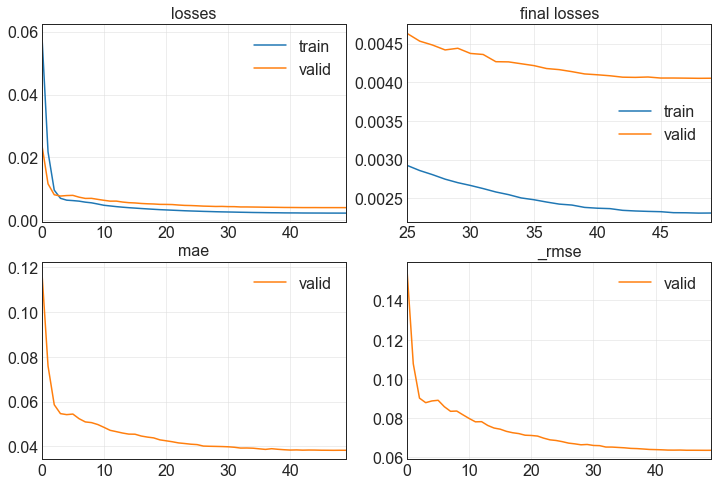

48.6250159740448                                                                                                       
[0.002309625269845128, 0.004051491152495146, 0.03823838382959366, 0.06365133076906204]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 63%|██████████████████████████▍               | 63/100 [1:33:44<36:54, 59.86s/trial, best loss: 0.0017745621735230088]

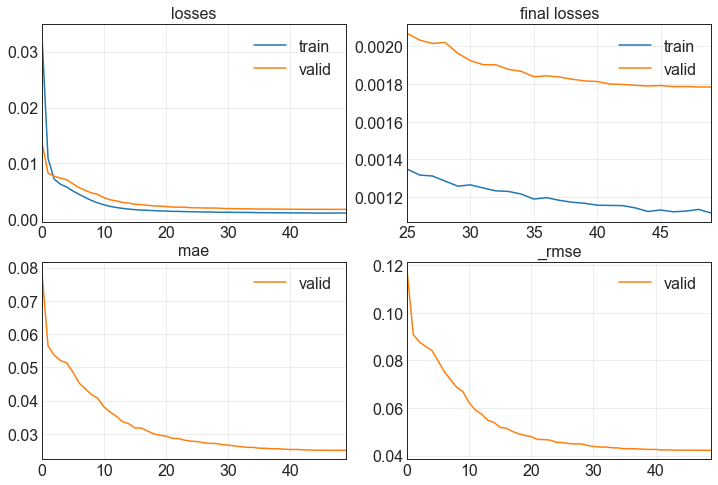

42.402748823165894                                                                                                     
[0.001114395447075367, 0.001784680294804275, 0.025080857798457146, 0.04224547743797302]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 3, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 64%|██████████████████████████▉               | 64/100 [1:34:28<32:58, 54.97s/trial, best loss: 0.0017745621735230088]

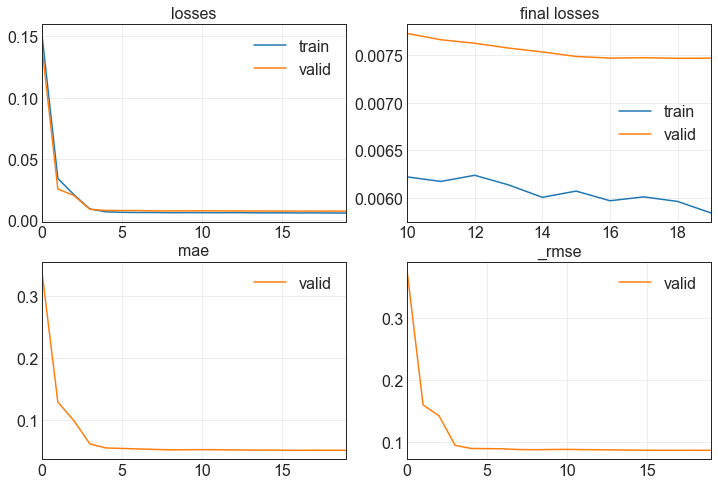

112.33249735832214                                                                                                     
[0.005838338285684586, 0.007470298558473587, 0.051764726638793945, 0.08643089979887009]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 65%|███████████████████████████▎              | 65/100 [1:36:21<42:18, 72.53s/trial, best loss: 0.0017745621735230088]

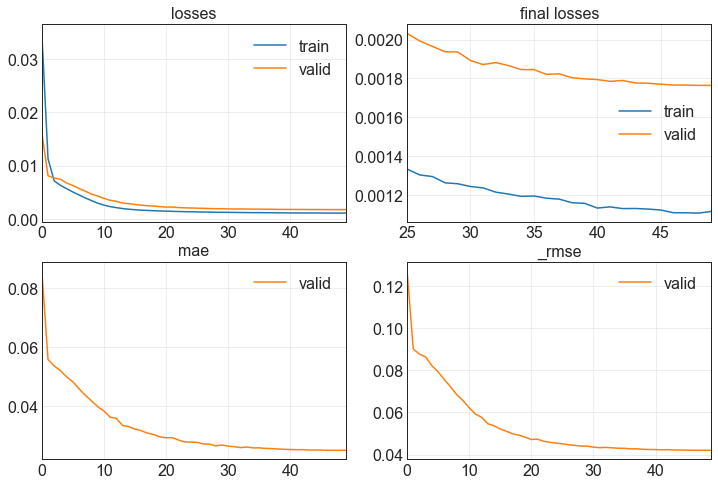

41.506547927856445                                                                                                     
[0.0011155449319630861, 0.001764278276823461, 0.024952858686447144, 0.042003314942121506]                              
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 66%|████████████████████████████▍              | 66/100 [1:37:04<36:01, 63.57s/trial, best loss: 0.001764278276823461]

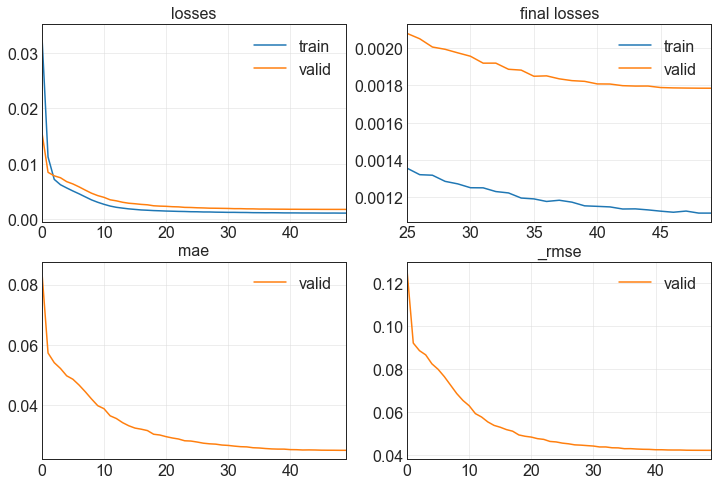

42.23451375961304                                                                                                      
[0.0011160103604197502, 0.0017849254654720426, 0.02510622888803482, 0.042248379439115524]                              
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 67%|████████████████████████████▊              | 67/100 [1:37:47<31:38, 57.53s/trial, best loss: 0.001764278276823461]

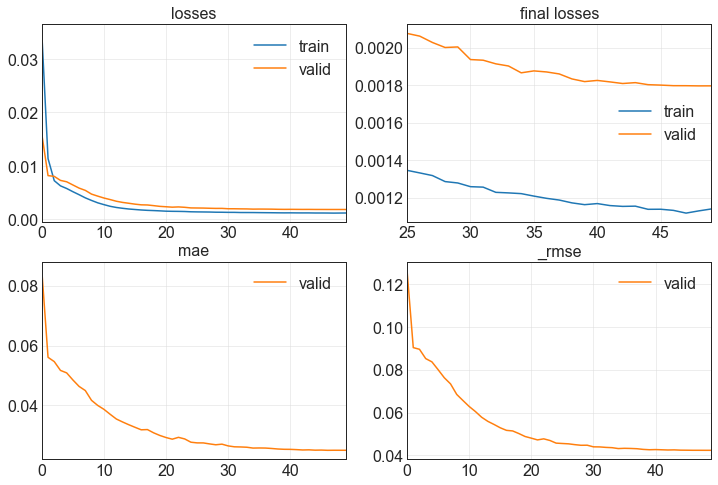

42.24820566177368                                                                                                      
[0.0011396028567105532, 0.0017956470837816596, 0.025042662397027016, 0.042375076562166214]                             
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 68%|█████████████████████████████▏             | 68/100 [1:38:31<28:25, 53.28s/trial, best loss: 0.001764278276823461]

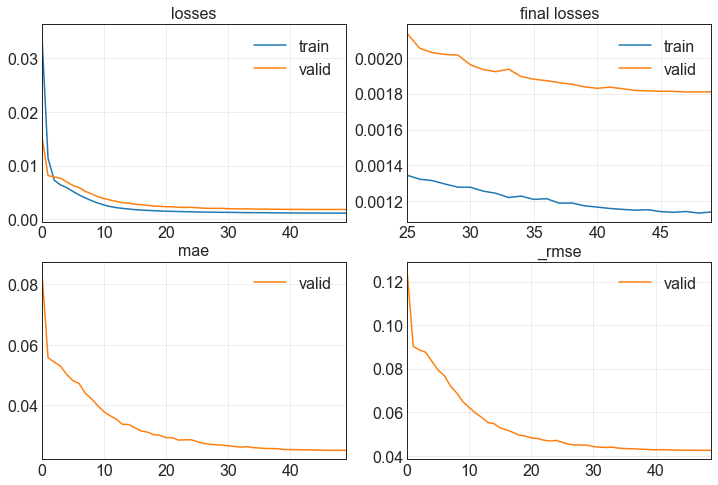

42.85165357589722                                                                                                      
[0.0011408051941543818, 0.0018098418368026614, 0.025214845314621925, 0.0425422377884388]                               
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 69%|█████████████████████████████▋             | 69/100 [1:39:15<26:05, 50.50s/trial, best loss: 0.001764278276823461]

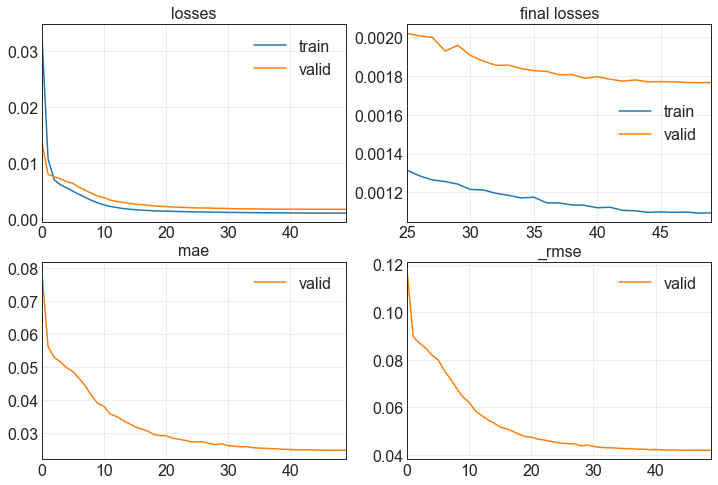

42.62246751785278                                                                                                      
[0.0010947478003799915, 0.001766975736245513, 0.024767830967903137, 0.042035408318042755]                              
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 70%|██████████████████████████████             | 70/100 [1:39:58<24:14, 48.48s/trial, best loss: 0.001764278276823461]

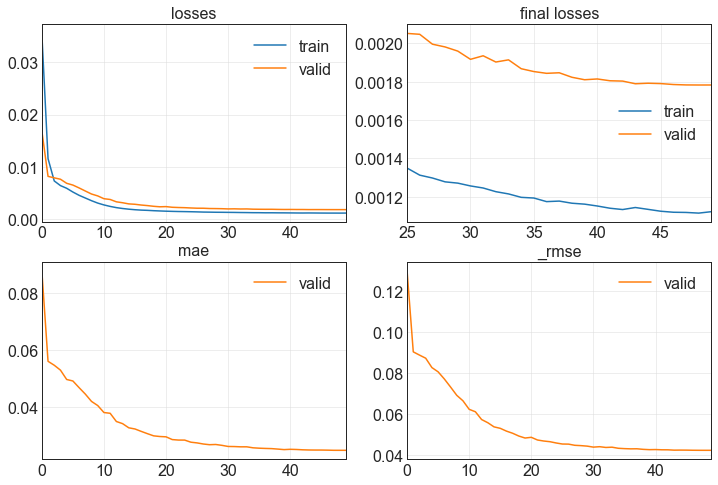

42.665531635284424                                                                                                     
[0.0011227282229810953, 0.0017832241719588637, 0.02502843365073204, 0.04222824051976204]                               
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 71%|██████████████████████████████▌            | 71/100 [1:40:42<22:45, 47.08s/trial, best loss: 0.001764278276823461]

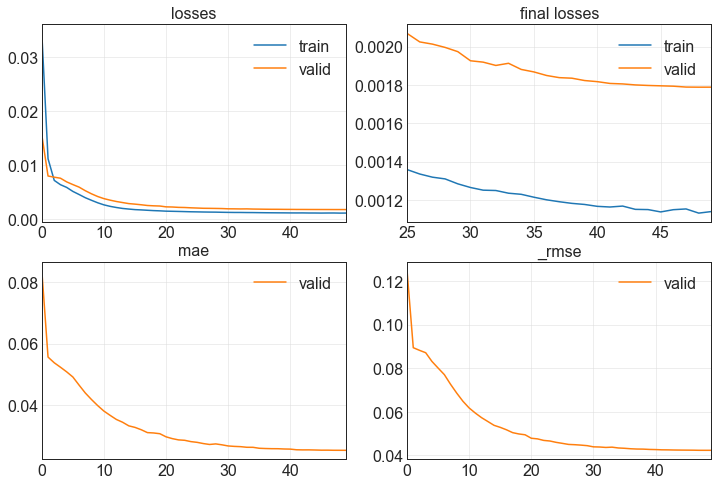

42.25936460494995                                                                                                      
[0.0011399618815630674, 0.0017887093126773834, 0.025103960186243057, 0.042293135076761246]                             
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 72%|██████████████████████████████▉            | 72/100 [1:41:26<21:27, 45.98s/trial, best loss: 0.001764278276823461]

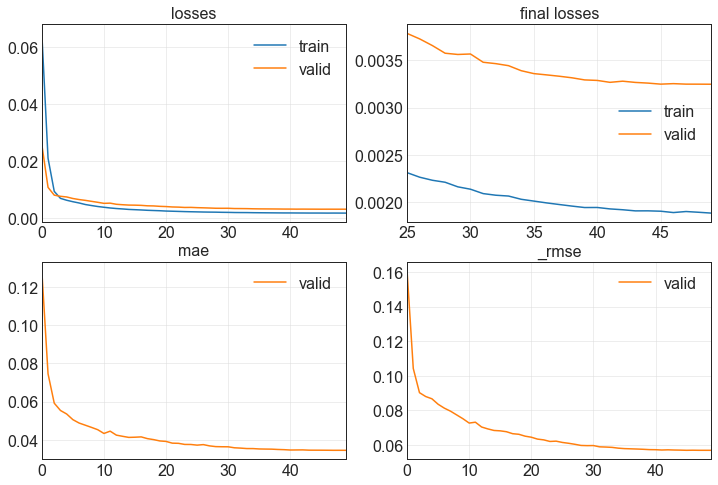

35.84482169151306                                                                                                      
[0.0018812050111591816, 0.0032471574377268553, 0.03454913944005966, 0.056983839720487595]                              
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 73%|███████████████████████████████▍           | 73/100 [1:42:03<19:28, 43.28s/trial, best loss: 0.001764278276823461]

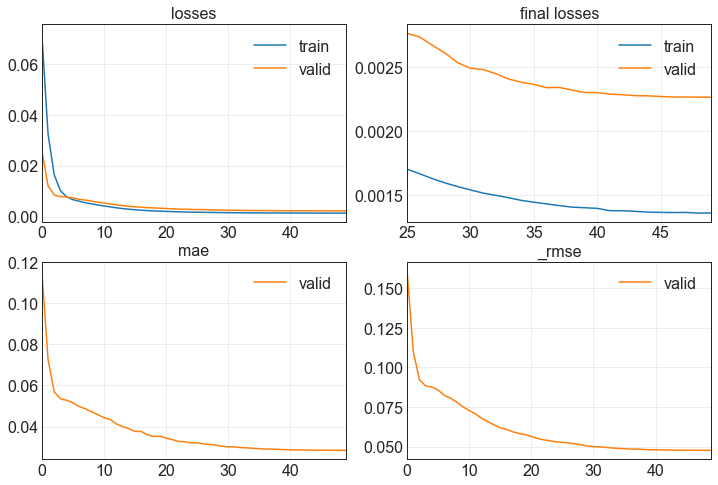

23.45958185195923                                                                                                      
[0.0013628730084747076, 0.0022644915152341127, 0.028415407985448837, 0.047586675733327866]                             
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 74%|███████████████████████████████▊           | 74/100 [1:42:27<16:19, 37.67s/trial, best loss: 0.001764278276823461]

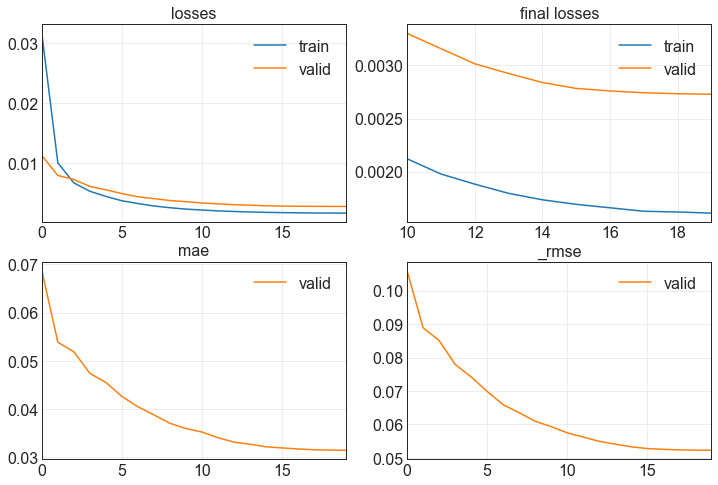

17.461568117141724                                                                                                     
[0.001609151135198772, 0.0027291099540889263, 0.03145211189985275, 0.05224088579416275]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 75%|████████████████████████████████▎          | 75/100 [1:42:46<13:19, 31.97s/trial, best loss: 0.001764278276823461]

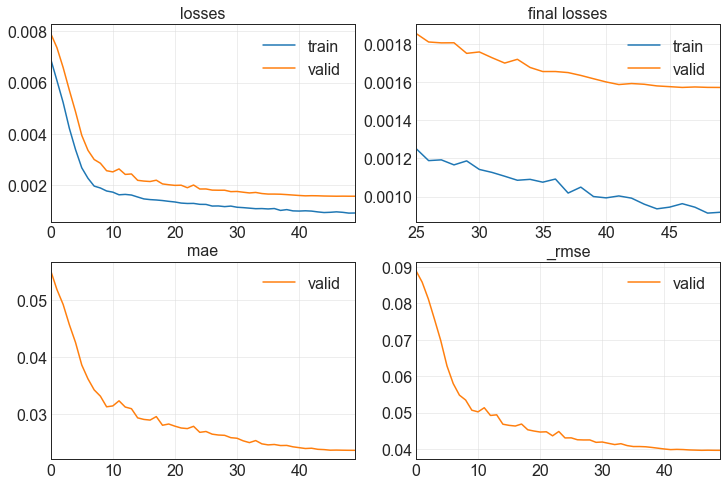

148.41058254241943                                                                                                     
[0.0009178490145131946, 0.0015715593472123146, 0.02357279136776924, 0.03964289650321007]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 5, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 76%|███████████████████████████████▉          | 76/100 [1:45:15<26:54, 67.28s/trial, best loss: 0.0015715593472123146]

No improvement since epoch 13: early stopping                                                                          
 76%|███████████████████████████████▉          | 76/100 [1:47:20<26:54, 67.28s/trial, best loss: 0.0015715593472123146]

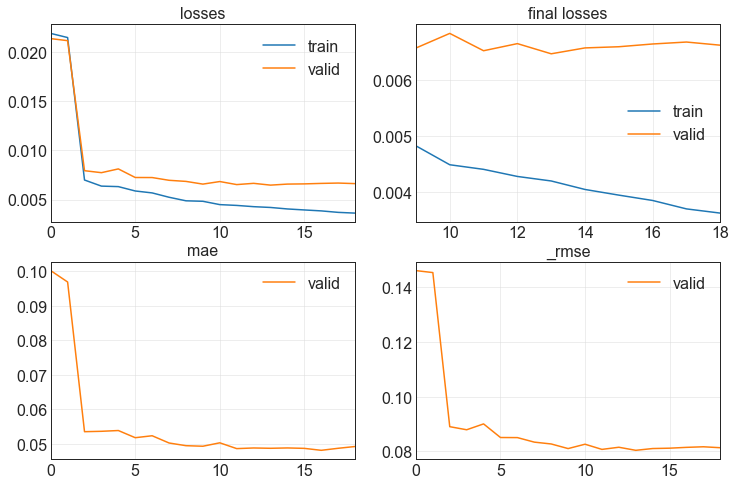

124.82285642623901                                                                                                     
[0.0036274318117648363, 0.006621775683015585, 0.049222830682992935, 0.08137428760528564]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 3, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 77%|████████████████████████████████▎         | 77/100 [1:47:21<32:32, 84.89s/trial, best loss: 0.0015715593472123146]

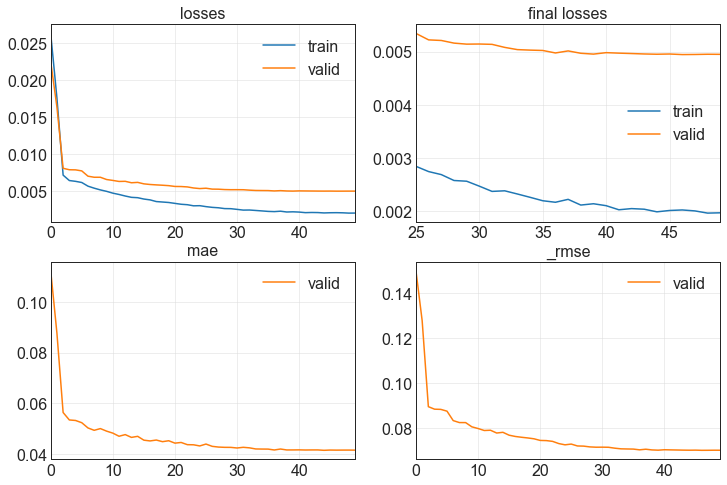

268.87413001060486                                                                                                     
[0.0019734615925699472, 0.004947209265083075, 0.04143527150154114, 0.07033640146255493]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 78%|███████████████████████████████▉         | 78/100 [1:51:51<51:29, 140.43s/trial, best loss: 0.0015715593472123146]

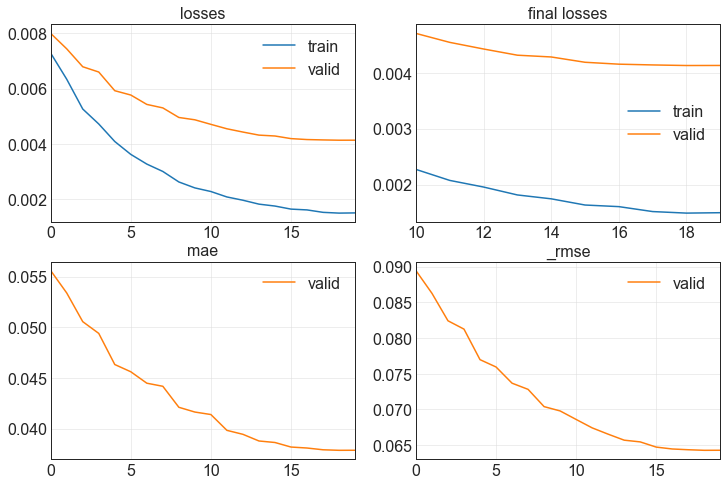

59.303670167922974                                                                                                     
[0.0014961266424506903, 0.004131837747991085, 0.03787345439195633, 0.06427937000989914]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 79%|████████████████████████████████▍        | 79/100 [1:52:52<40:45, 116.43s/trial, best loss: 0.0015715593472123146]

No improvement since epoch 11: early stopping                                                                          
 79%|████████████████████████████████▍        | 79/100 [1:54:44<40:45, 116.43s/trial, best loss: 0.0015715593472123146]

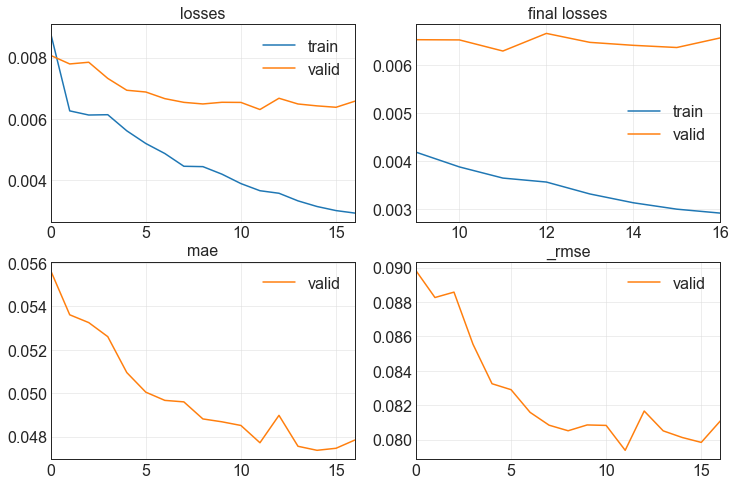

112.97580218315125                                                                                                     
[0.002916634315624833, 0.006574622355401516, 0.047846343368291855, 0.08108404278755188]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.0001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 80%|████████████████████████████████▊        | 80/100 [1:54:46<38:34, 115.74s/trial, best loss: 0.0015715593472123146]

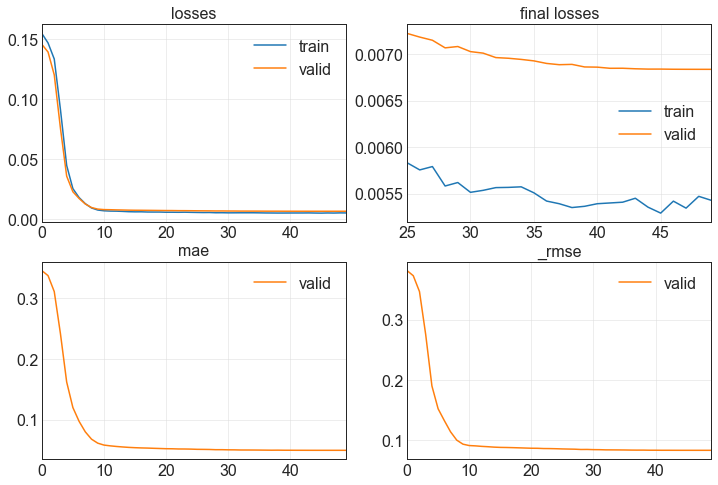

134.9790816307068                                                                                                      
[0.005428338423371315, 0.0068347034975886345, 0.04933934286236763, 0.08267227560281754]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 81%|█████████████████████████████████▏       | 81/100 [1:57:02<38:35, 121.85s/trial, best loss: 0.0015715593472123146]

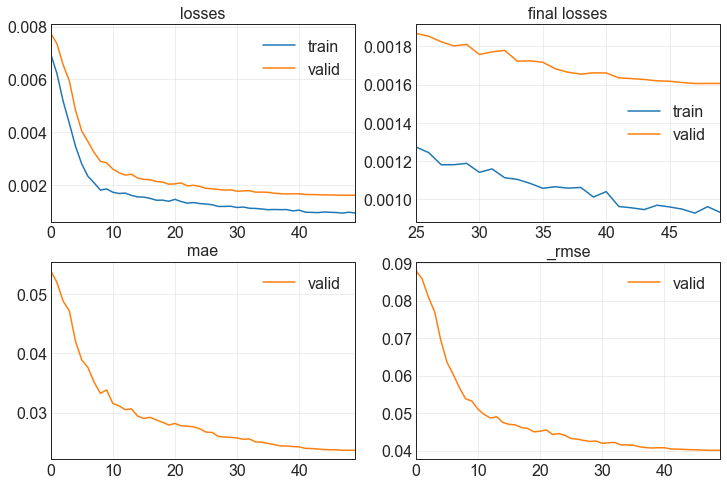

154.2643506526947                                                                                                      
[0.0009321945835836232, 0.0016066747484728694, 0.023651206865906715, 0.040083348751068115]                             
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 82%|█████████████████████████████████▌       | 82/100 [1:59:38<39:34, 131.91s/trial, best loss: 0.0015715593472123146]

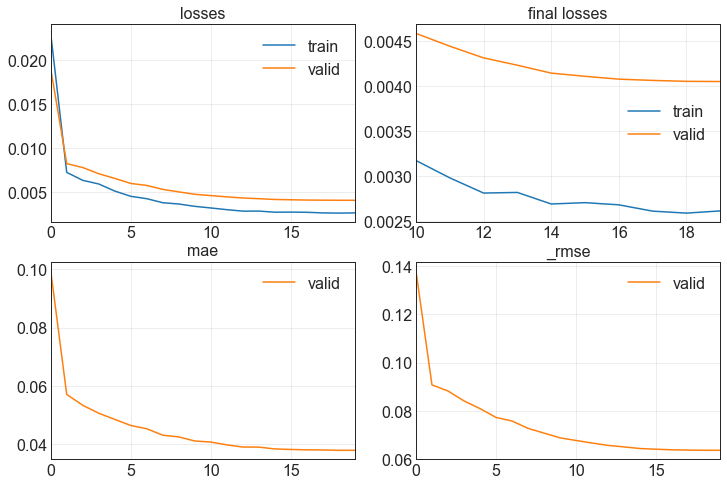

62.29286766052246                                                                                                      
[0.0026106159202754498, 0.004047755617648363, 0.03787653148174286, 0.06362196803092957]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 83%|██████████████████████████████████       | 83/100 [2:00:41<31:33, 111.38s/trial, best loss: 0.0015715593472123146]

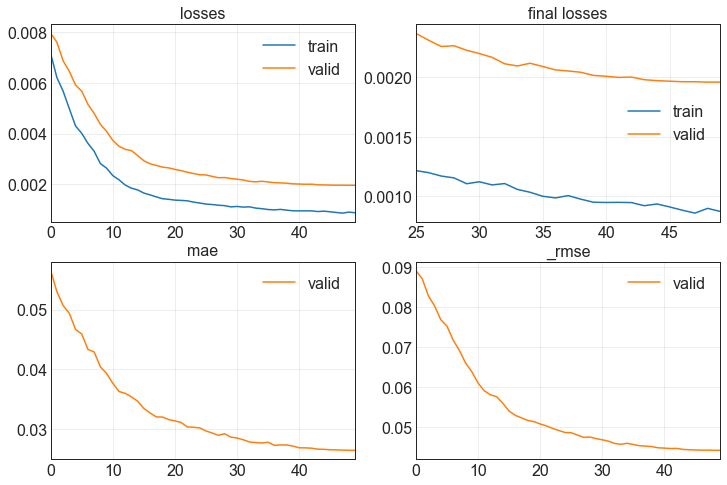

122.43008422851562                                                                                                     
[0.0008743098587729037, 0.00195971317589283, 0.02640480175614357, 0.0442686527967453]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 5, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 84%|██████████████████████████████████▍      | 84/100 [2:02:45<30:40, 115.04s/trial, best loss: 0.0015715593472123146]

No improvement since epoch 17: early stopping                                                                          
 84%|██████████████████████████████████▍      | 84/100 [2:05:52<30:40, 115.04s/trial, best loss: 0.0015715593472123146]

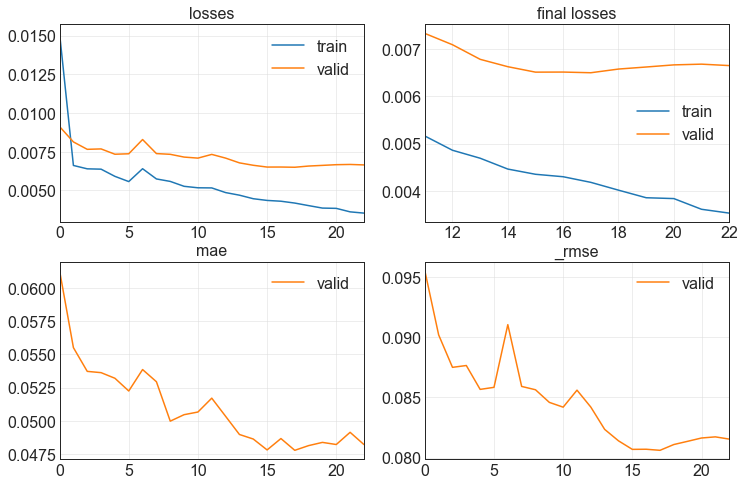

188.12705063819885                                                                                                     
[0.0035343964118510485, 0.006648005917668343, 0.04821375384926796, 0.08153530210256577]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.0001, 'n_layers': 3, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 85%|██████████████████████████████████▊      | 85/100 [2:05:54<34:20, 137.34s/trial, best loss: 0.0015715593472123146]

No improvement since epoch 27: early stopping                                                                          
 85%|██████████████████████████████████▊      | 85/100 [2:08:32<34:20, 137.34s/trial, best loss: 0.0015715593472123146]

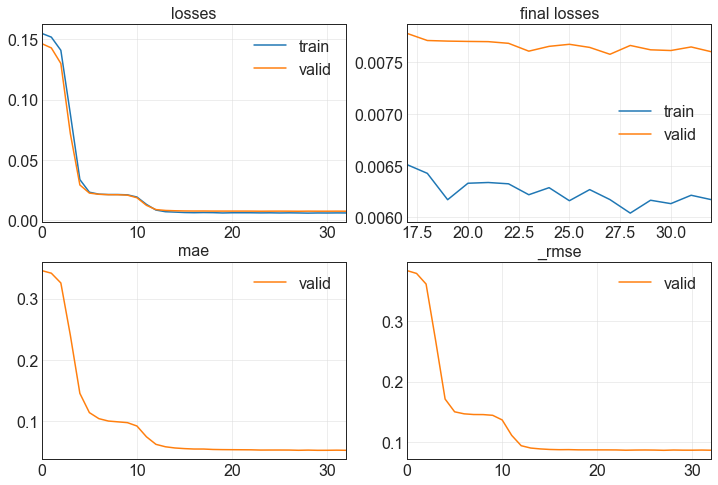

158.23741674423218                                                                                                     
[0.006171616725623608, 0.007603728678077459, 0.05252680554986, 0.08719935268163681]                                    
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 86%|███████████████████████████████████▎     | 86/100 [2:08:33<33:35, 143.96s/trial, best loss: 0.0015715593472123146]

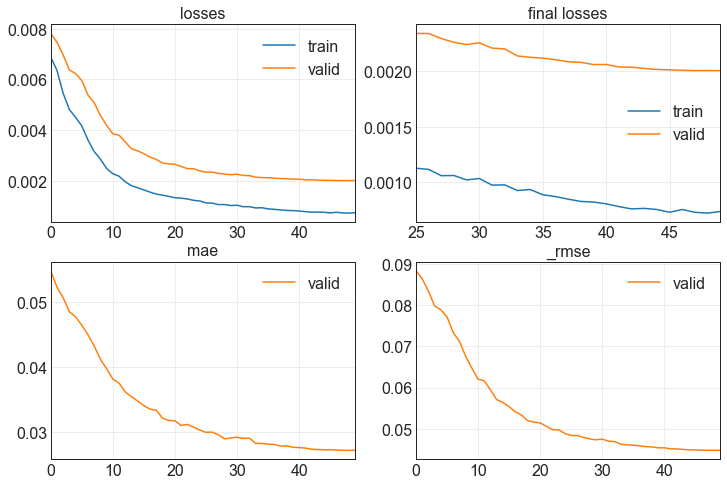

219.89735960960388                                                                                                     
[0.0007366110803559422, 0.002005870919674635, 0.027183255180716515, 0.044786952435970306]                              
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 87%|███████████████████████████████████▋     | 87/100 [2:12:14<36:12, 167.08s/trial, best loss: 0.0015715593472123146]

No improvement since epoch 11: early stopping                                                                          
 87%|███████████████████████████████████▋     | 87/100 [2:13:26<36:12, 167.08s/trial, best loss: 0.0015715593472123146]

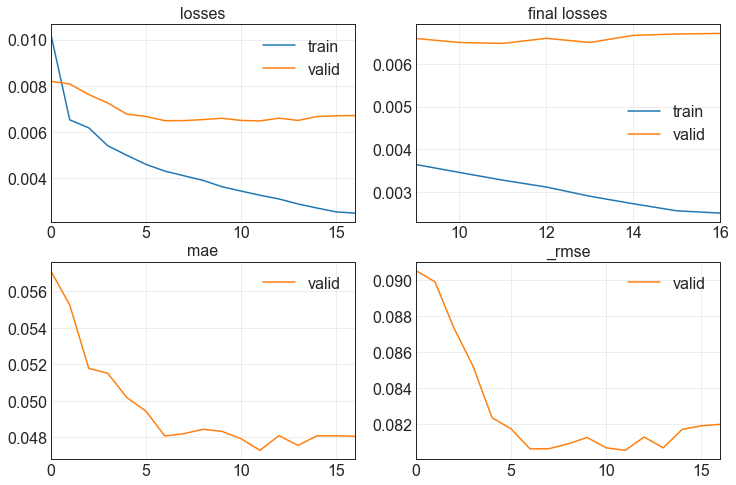

72.37147831916809                                                                                                      
[0.0025012276601046324, 0.006720573175698519, 0.04806627333164215, 0.08197910338640213]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 88%|████████████████████████████████████     | 88/100 [2:13:28<27:48, 139.03s/trial, best loss: 0.0015715593472123146]

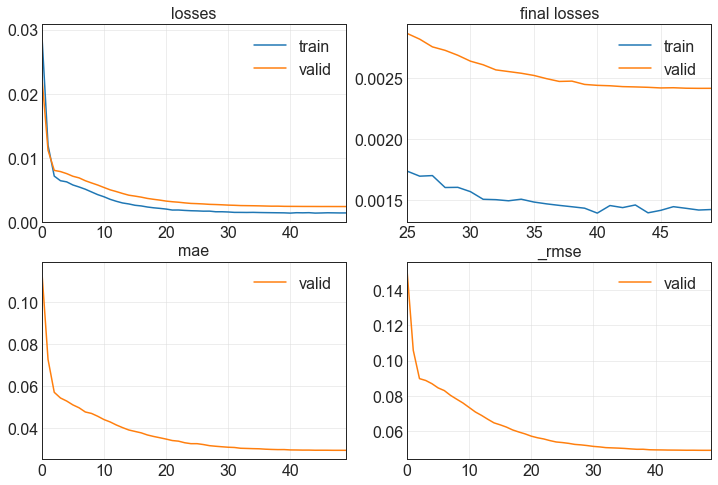

153.74006748199463                                                                                                     
[0.00142112304456532, 0.0024161243345588446, 0.029338186606764793, 0.049154091626405716]                               
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 89%|████████████████████████████████████▍    | 89/100 [2:16:03<26:21, 143.78s/trial, best loss: 0.0015715593472123146]

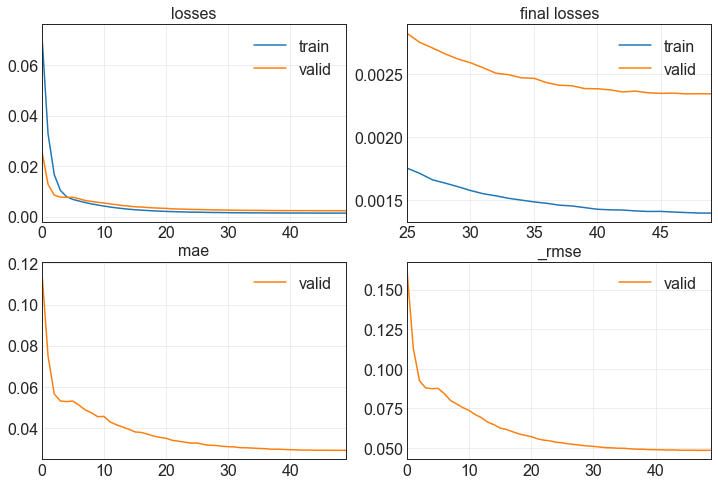

24.082969903945923                                                                                                     
[0.0013944199308753014, 0.002343854634091258, 0.029097341001033783, 0.04841337352991104]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 90%|████████████████████████████████████▉    | 90/100 [2:16:28<18:02, 108.27s/trial, best loss: 0.0015715593472123146]

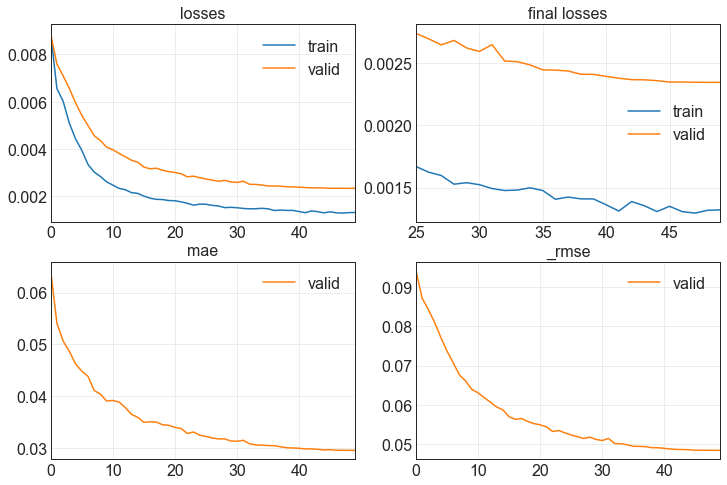

140.81868505477905                                                                                                     
[0.0013222538400441408, 0.0023433926980942488, 0.029557570815086365, 0.04840859770774841]                              
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 5, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 91%|█████████████████████████████████████▎   | 91/100 [2:18:50<17:45, 118.38s/trial, best loss: 0.0015715593472123146]

No improvement since epoch 19: early stopping                                                                          
 91%|█████████████████████████████████████▎   | 91/100 [2:22:11<17:45, 118.38s/trial, best loss: 0.0015715593472123146]

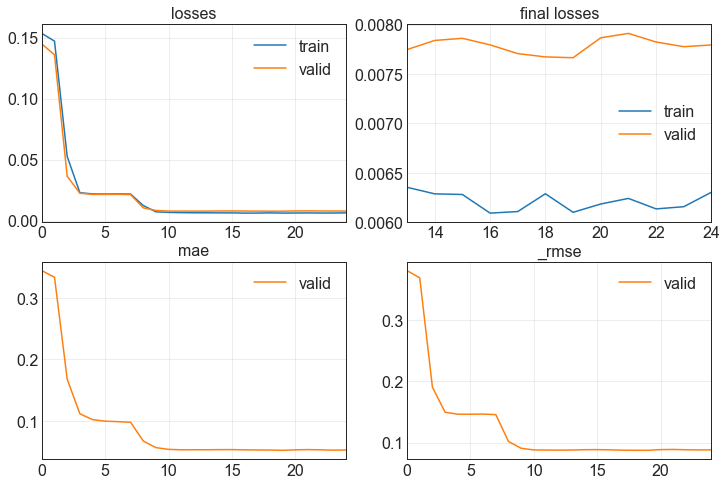

201.6123492717743                                                                                                      
[0.0063026039861142635, 0.007794681005179882, 0.05242007598280907, 0.08828748762607574]                                
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 92%|█████████████████████████████████████▋   | 92/100 [2:22:13<19:09, 143.72s/trial, best loss: 0.0015715593472123146]

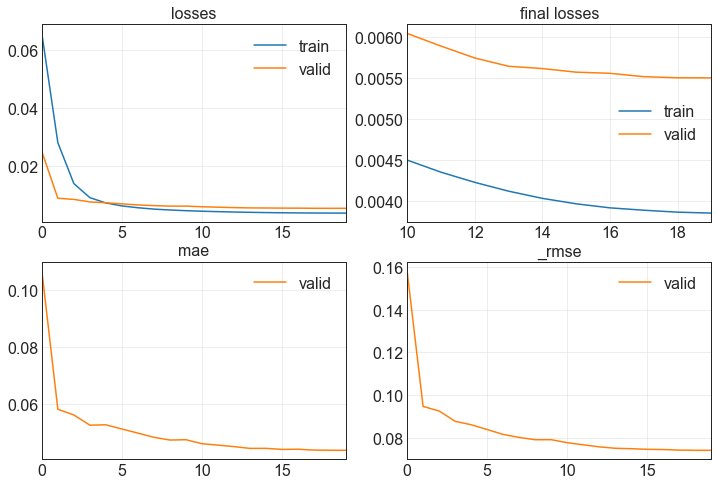

7.882999658584595                                                                                                      
[0.0038535725325345993, 0.005501437466591597, 0.04376314580440521, 0.07417166978120804]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 2, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 93%|██████████████████████████████████████▏  | 93/100 [2:22:22<12:03, 103.32s/trial, best loss: 0.0015715593472123146]

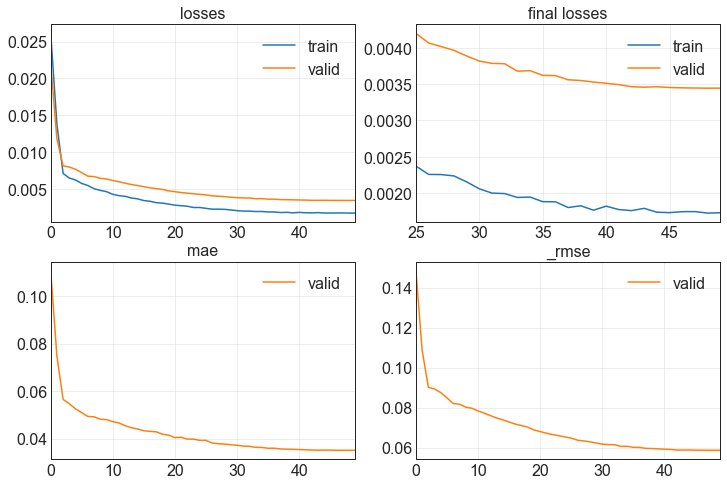

217.4288604259491                                                                                                      
[0.001731713768094778, 0.0034445063211023808, 0.03509680554270744, 0.058689918369054794]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 94%|██████████████████████████████████████▌  | 94/100 [2:26:01<13:47, 137.90s/trial, best loss: 0.0015715593472123146]

No improvement since epoch 14: early stopping                                                                          
 94%|██████████████████████████████████████▌  | 94/100 [2:28:18<13:47, 137.90s/trial, best loss: 0.0015715593472123146]

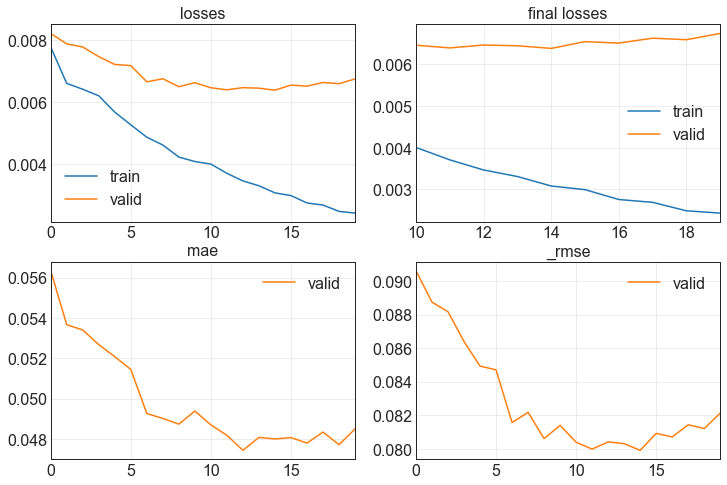

138.00518822669983                                                                                                     
[0.0024329544976353645, 0.006746284198015928, 0.04849548637866974, 0.08213576674461365]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 95%|██████████████████████████████████████▉  | 95/100 [2:28:20<11:31, 138.29s/trial, best loss: 0.0015715593472123146]

No improvement since epoch 39: early stopping                                                                          
 95%|██████████████████████████████████████▉  | 95/100 [2:31:59<11:31, 138.29s/trial, best loss: 0.0015715593472123146]

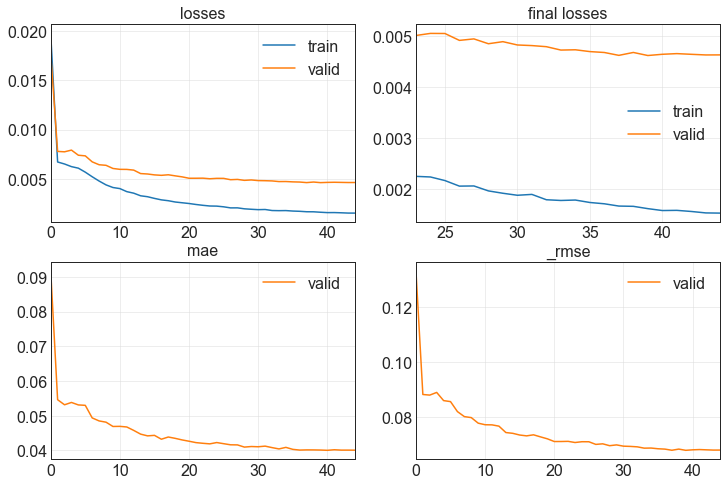

219.91749572753906                                                                                                     
[0.001528988010250032, 0.004632886964827776, 0.04008582606911659, 0.06806530803442001]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 96%|███████████████████████████████████████▎ | 96/100 [2:32:01<10:52, 163.14s/trial, best loss: 0.0015715593472123146]

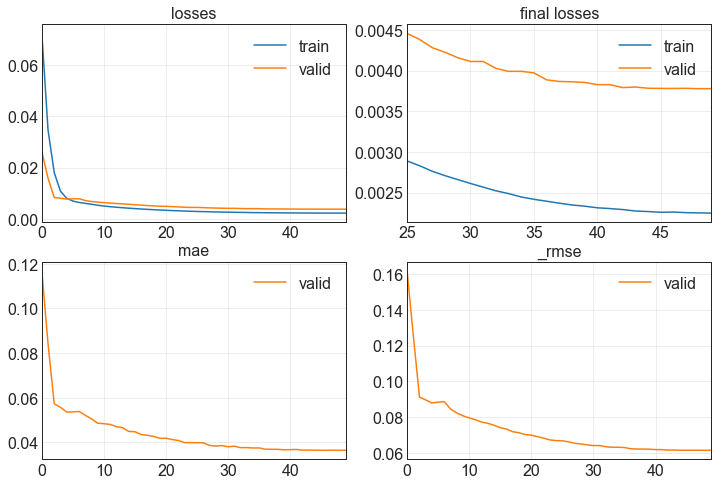

18.54733109474182                                                                                                      
[0.0022480131592601538, 0.0037784145679324865, 0.036455195397138596, 0.06146881356835365]                              
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.0001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 97%|███████████████████████████████████████▊ | 97/100 [2:32:21<06:00, 120.12s/trial, best loss: 0.0015715593472123146]

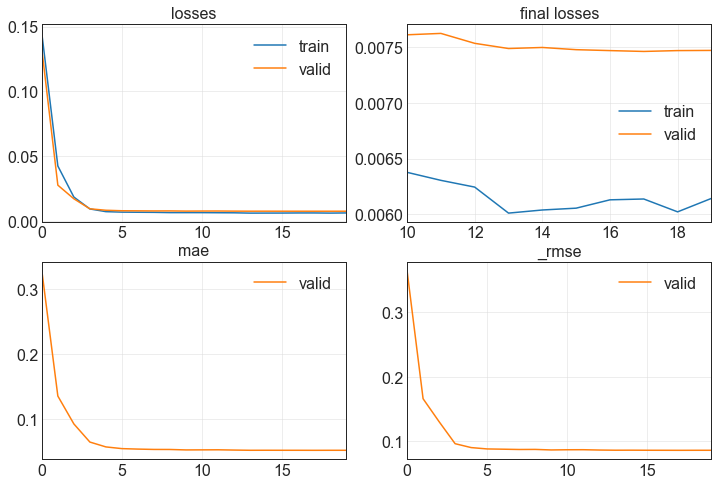

63.29178547859192                                                                                                      
[0.006143149454146624, 0.00746923265978694, 0.05204211175441742, 0.08642472326755524]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 98%|████████████████████████████████████████▏| 98/100 [2:33:25<03:26, 103.42s/trial, best loss: 0.0015715593472123146]

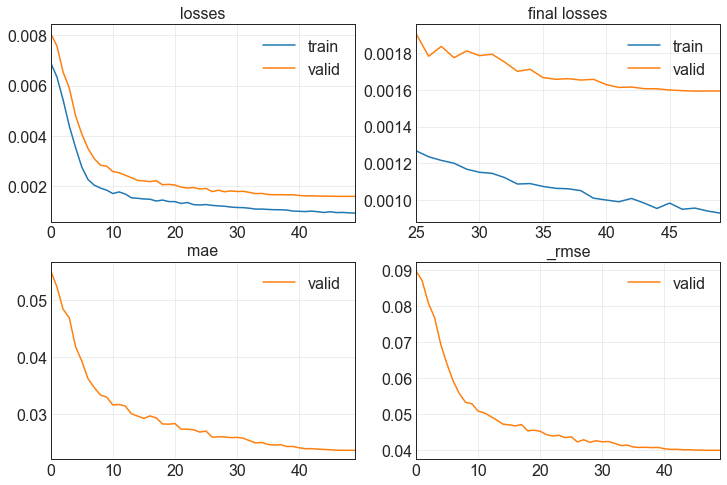

153.84668970108032                                                                                                     
[0.0009283071849495173, 0.0015944915357977152, 0.02362094260752201, 0.03993108496069908]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 2, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}
LSTM                                                                                                                   
 99%|████████████████████████████████████████▌| 99/100 [2:36:00<01:58, 118.93s/trial, best loss: 0.0015715593472123146]

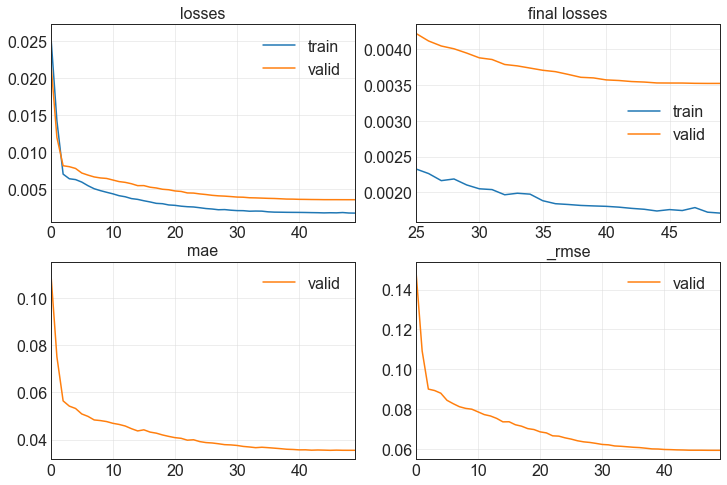

216.2305223941803                                                                                                      
[0.0017107215244323015, 0.0035218833945691586, 0.0354582779109478, 0.05934545770287514]                                
100%|█████████████████████████████████████████| 100/100 [2:39:37<00:00, 95.77s/trial, best loss: 0.0015715593472123146]


In [57]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=max_evals,  # test trials
    trials=trials)

In [58]:
print("Best parameters:")
print(space_eval(search_space, best))
params = space_eval(search_space, best)

Best parameters:
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DE0D9C4438>, 'patience': 5}


In [59]:
# only for debug
# params = {'batch_size': 16, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 5, 'optimizer': Adam, 'patience': 10}

# Retrain the model with best hyperparameter

We use training data for training and validation data for (possible) early stopping:

In [60]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [61]:
X.shape

(7990, 196, 10)

In [62]:
y.shape

(7990, 196)

In [63]:
batch_size = params["batch_size"]

In [64]:
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
# set num_workers for memory bottleneck
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)

Create the model:

In [65]:
arch = LSTM
k = {
    'n_layers': params['n_layers'],
    'hidden_size': params['hidden_size'],
    'bidirectional': params['bidirectional']
}
model = create_model(arch, dls=dls, **k)
print(model.__class__.__name__)

LSTM


In [66]:
model

LSTM(
  (rnn): LSTM(196, 200, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=400, out_features=196, bias=True)
)

In [67]:
# Add a Sigmoid layer
model = nn.Sequential(model, nn.Sigmoid())

In [68]:
model

Sequential(
  (0): LSTM(
    (rnn): LSTM(196, 200, batch_first=True, bidirectional=True)
    (fc): Linear(in_features=400, out_features=196, bias=True)
  )
  (1): Sigmoid()
)

In [69]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

715,396 total parameters.
715,396 training parameters.


Training the model:

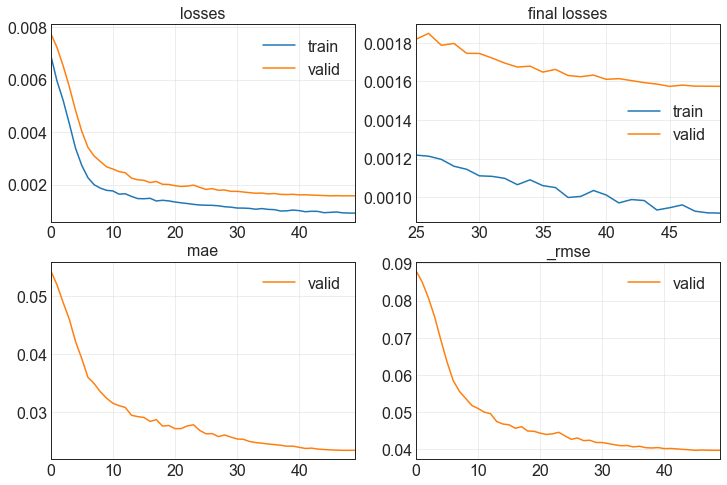

In [70]:
learn = Learner(dls, model, metrics=[mae, rmse], opt_func=params['optimizer'])
start = time.time()
learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                    cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
training_time = time.time() - start
learn.plot_metrics()

Evaluate the model:

In [71]:
dls = learn.dls
valid_dl = dls.valid

In [72]:
test_ds = valid_dl.dataset.add_test(X_test, y_test)  # use the test data
test_dl = valid_dl.new(test_ds)
print(test_dl.n)

1999


In [73]:
start = time.time()
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
prediction_time = time.time() - start
test_probas, test_targets, test_preds

(tensor([[0.6647, 0.1910, 0.7672,  ..., 0.5102, 0.0018, 0.0019],
         [0.7039, 0.1931, 0.7483,  ..., 0.5230, 0.0019, 0.0020],
         [0.7391, 0.2068, 0.7155,  ..., 0.4960, 0.0021, 0.0022],
         ...,
         [0.7625, 0.1634, 0.6650,  ..., 0.7152, 0.0025, 0.0025],
         [0.7917, 0.1740, 0.6664,  ..., 0.6951, 0.0026, 0.0026],
         [0.7933, 0.1670, 0.6592,  ..., 0.6727, 0.0026, 0.0025]]),
 tensor([[0.7516, 0.2175, 0.7770,  ..., 0.5197, 0.0000, 0.0000],
         [0.7553, 0.2080, 0.7623,  ..., 0.5126, 0.0000, 0.0000],
         [0.7457, 0.1962, 0.7510,  ..., 0.4877, 0.0000, 0.0000],
         ...,
         [0.7723, 0.1825, 0.6382,  ..., 0.6950, 0.0000, 0.0000],
         [0.7608, 0.1724, 0.6434,  ..., 0.6812, 0.0000, 0.0000],
         [0.7262, 0.1734, 0.6523,  ..., 0.6877, 0.0000, 0.0000]]),
 tensor([[0.6647, 0.1910, 0.7672,  ..., 0.5102, 0.0018, 0.0019],
         [0.7039, 0.1931, 0.7483,  ..., 0.5230, 0.0019, 0.0020],
         [0.7391, 0.2068, 0.7155,  ..., 0.4960, 0.0021, 0.

In [74]:
test_targets.shape

torch.Size([1999, 196])

In [75]:
test_preds.shape

torch.Size([1999, 196])

In [76]:
y_true = test_targets.numpy()
y_pred = test_preds.numpy()

Reshape the data into multiple steps

In [77]:
y_true = y_true.reshape(y_true.shape[0], horizon, -1)
y_pred = y_pred.reshape(y_pred.shape[0], horizon, -1)

In [78]:
y_true.shape

(1999, 1, 196)

In [79]:
y_pred.shape

(1999, 1, 196)

Transform the data in the normal range:

In [80]:
def inverse_normalization(prediction, y, max_list, min_list):
    inverse_prediction = prediction * (max_list - min_list) + min_list
    inverse_y = y * (max_list - min_list) + min_list

    return inverse_prediction, inverse_y

In [81]:
y_true_list = []
y_pred_list = []
for i in range(y_true.shape[0]):
    y_true_tmp = []
    y_pred_tmp = []
    for step in range(y_true.shape[1]):
        inverse_prediction, inverse_y = inverse_normalization(y_pred[i, step, :], y_true[i, step, :], max_list, min_list)
        
        y_true_tmp.append(inverse_y)
        y_pred_tmp.append(inverse_prediction)
    y_true_list.append(y_true_tmp)
    y_pred_list.append(y_pred_tmp)

In [82]:
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

In [83]:
y_true.shape

(1999, 1, 196)

In [84]:
y_pred.shape

(1999, 1, 196)

# Save Predictions and Evaluate Model

Save true values and predictions first:

In [85]:
pickle.dump(y_pred, open(y_pred_fn, 'wb'))

In [86]:
pickle.dump(y_true, open(y_true_fn, 'wb'))

The training and test time spent:

In [87]:
print('Training time (in seconds): ', training_time)
print('Test time (in seconds): ', prediction_time)

Training time (in seconds):  153.13660311698914
Test time (in seconds):  0.49289774894714355


In [93]:
print('Training time (in seconds) per epoch: ', 153.13660311698914 / 50)

Training time (in seconds) per epoch:  3.0627320623397827


Calculate the RMSE and MAE for differnt time steps:

In [89]:
for step in range(horizon):
    print('Prediction for the next %d frame' % (step + 1))
    print('RMSE: ', math.sqrt(mean_squared_error(y_true[:, step, :].flatten(), y_pred[:, step, :].flatten())) / 1000)  # in Mbps
    print('MAE: ', mean_absolute_error(y_true[:, step, :].flatten(), y_pred[:, step, :].flatten()) / 1000 )

Prediction for the next 1 frame
RMSE:  32.005647096059754
MAE:  9.255177989210365


Plot the RMSE and MAE distributions for each time step:

In [90]:
def plot_RMSE(y_true, y_pred, fn, xlim=60):
    RMSE_list = []

    for i in range(y_true.shape[0]):
        rmse = math.sqrt(mean_squared_error(y_true[i].flatten(), y_pred[i].flatten())) / 1000
        RMSE_list.append(rmse)
    
    data = RMSE_list
    data_size = len(data)
    data_set = sorted(set(data))
    bins = np.append(data_set, data_set[-1] + 1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts = counts.astype(float) / data_size
    
    plt.figure(figsize=[12, 9])
    plt.xlabel("RMSE (Mbps)")
    plt.xlim((0, xlim))
    plt.ylabel("CDF")
    plt.ylim((0, 1))

    # Format the x tick labels
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf)
    
    plt.savefig(fn, bbox_inches = 'tight', pad_inches = 0.1)

In [91]:
def plot_MAE(y_true, y_pred, fn, xlim=60):
    MAE_list = []

    for i in range(y_true.shape[0]):
        mae = mean_absolute_error(y_true[i].flatten(), y_pred[i].flatten()) / 1000
        MAE_list.append(mae)
    
    data = MAE_list
    data_size = len(data)
    data_set = sorted(set(data))
    bins = np.append(data_set, data_set[-1] + 1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts = counts.astype(float) / data_size
    
    plt.figure(figsize=[12, 9])
    plt.xlabel("MAE (Mbps)")
    plt.xlim((0, xlim))
    plt.ylabel("CDF")
    plt.ylim((0, 1))

    # Format the x tick labels
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf)
    
    plt.savefig(fn, bbox_inches = 'tight', pad_inches = 0.1)

LSTM_TM-minmax_RMSE-10-1-step-1.pdf
LSTM_TM-minmax_MAE-10-1-step-1.pdf


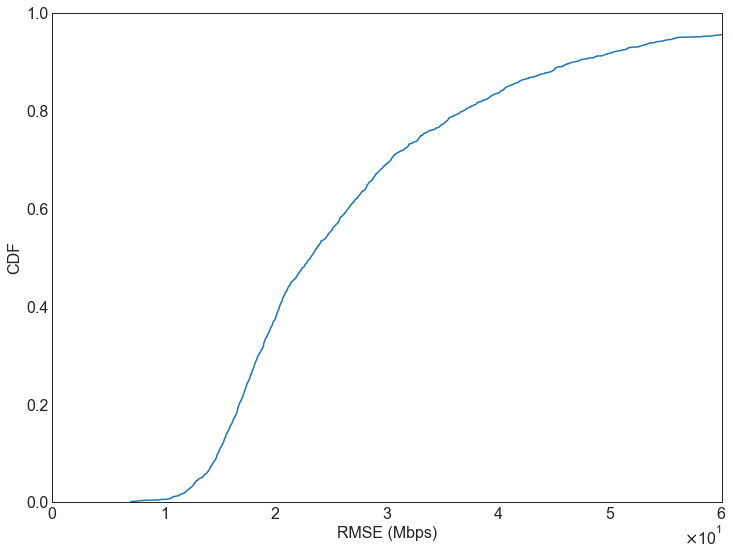

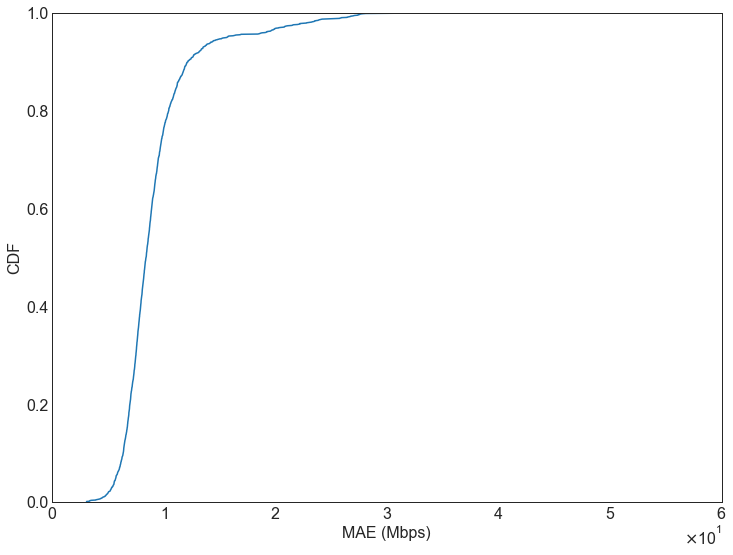

In [92]:
for step in range(horizon):
    fn = RMSE_fn % (history, horizon, step + 1)
    print(fn)
    
    plot_RMSE(y_true[:, step, :], y_pred[:, step, :], fn)
    
    fn = MAE_fn % (history, horizon, step + 1)
    print(fn)
    
    plot_MAE(y_true[:, step, :], y_pred[:, step, :], fn)